<a href="https://colab.research.google.com/github/aleksandr95chernykh/Generation-Pixel-Art-Trees/blob/main/_pixel_art_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
# Библиотека Numpy
import numpy as np

# Библиотека PIL
from PIL import Image

# Библиотека keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, concatenate, Conv2DTranspose, Conv2D, LeakyReLU, ReLU, multiply
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Вспомогательные модули
import os
import random
import gdown

# Библиотека Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка датасета через gdown.download и распаковка архива

In [ ]:
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1mWAzdP9Y9n-5EYduImCVSENSjnxDH0RT', None, quiet=True)

'dataset.zip'

In [ ]:
!unzip -qo dataset.zip -d pixel_art_trees/
!ls pixel_art_trees

dataset


# Подготовка данных

In [ ]:
# Гиперпараметры

img_widht = 16                                                                  # Ширина изображения
img_height = 16                                                                 # Высота изображения
channels = 4                                                                    # Количество каналов изображения
img_shape = (img_widht, img_height, channels)                                   # Ширина, высота и количество каналов изображения

random_vec = 100                                                                # Размер вектора для генератора

batch_size = 128                                                                # Количество обучающих примеров за одну итерацию
n_classes = 6                                                                   # Количество классов изображений

In [ ]:
def data_processing():

  IMAGE_PATH = '/content/pixel_art_trees/dataset/'                                              # Путь к изображениям

  CLASS_LIST = sorted(os.listdir(IMAGE_PATH))                                   # Названия меток класса из датасета

  CLASS_COUNT = len(CLASS_LIST)                                                 # Количество меток класса из датасета

  for cls in CLASS_LIST:                                                        # Формирование пути к датасету
    cls, ':', os.listdir(f'{IMAGE_PATH}{cls}')


  x_train = []                                                                  # Контейнер для изображений
  train_labels = []                                                             # Контейнер для меток классов

  for class_label in range(CLASS_COUNT):
    class_name = CLASS_LIST[class_label]
    class_path = IMAGE_PATH + class_name
    class_files = os.listdir(class_path)
    x_train += [f'{class_path}/{file_name}' for file_name in class_files]
    train_labels += [class_label] * len(class_files) # Лейблы

  data_images = []                                                              # Пустой контейнер для изображений

  for file_name in x_train:                                                     # Открытие изображений
    img = Image.open(file_name)
    img_np = np.array(img)
    data_images.append(img_np)

  x_train = np.array(data_images)                                               # Преобразование изображений в массив Numpy
  train_labels = np.array(train_labels)                                         # Преобразование меток классов в массив Numpy

  x_train = x_train / 127.5 -1                                                  # Нормализация

  train_labels = utils.to_categorical(train_labels, CLASS_COUNT)                # Перевод меток классов в формат OHE

  return x_train, train_labels, CLASS_COUNT, CLASS_LIST                         # Функция возвращает: Изображения, Метки классов, Количество меток классов и Названия меток классов.

In [ ]:
x_train, train_labels, CLASS_COUNT, CLASS_LIST = data_processing()              # Применяем самописную функцию

In [ ]:
# Проверяем результат
print(x_train.shape)                                                            # Изображения (19198, 16, 16, 4)
print(train_labels.shape)                                                       # Метки классов (19198, 6)
print(CLASS_COUNT)                                                              # Количество меток классов - 6
print(CLASS_LIST)                                                               # Названия меток классов ['cherry', 'jungle', 'oak', 'old', 'slime', 'swamp']

(19198, 16, 16, 4)
(19198, 6)
6
['cherry', 'jungle', 'oak', 'old', 'slime', 'swamp']


In [ ]:
def show_dataset():
  idx = 1                                                            # Функция отрисовки изображений из датасета
  for j in range(6):
    plt.figure(figsize=(15, 15))
    for i in range(12):
      plt.subplot(6, 12, i+1)
      idx = idx + 1
      img = (x_train + 1) * 127.5
      plt.imshow(img[idx].astype('uint8'))
      plt.axis('off')
    plt.show()
    idx = idx +3200
  plt.close()

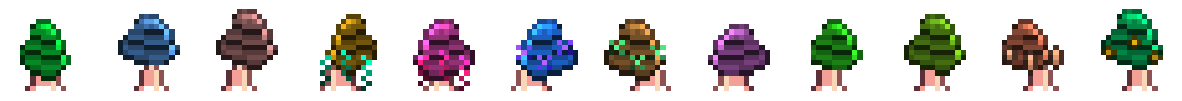

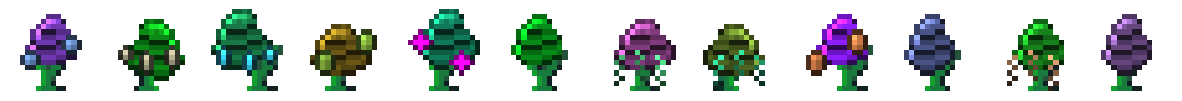

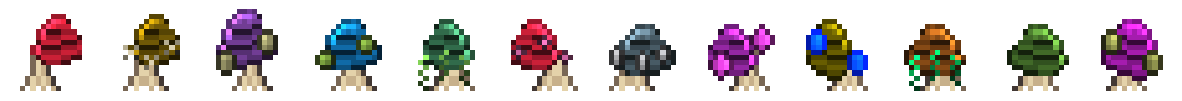

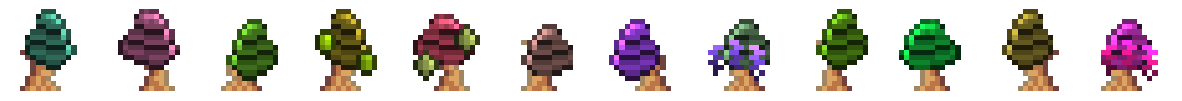

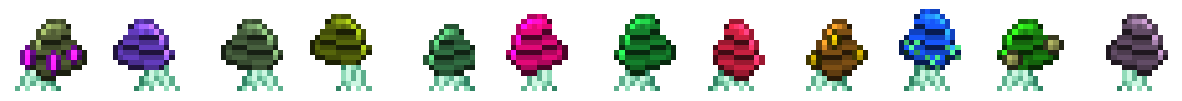

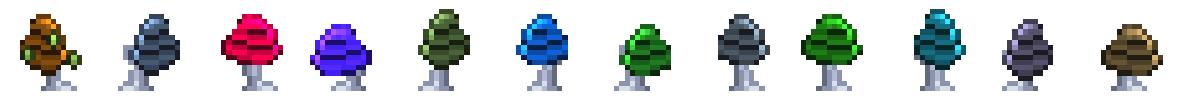

In [ ]:
show_dataset()

# Генератор

In [ ]:
def create_generator(random_vec, n_classes):

  noise_input = Input(shape=(random_vec))                                       # Вход для вектора
  noise = Dense(16*16*256)(noise_input)
  noise = ReLU()(noise)
  noise = BatchNormalization(momentum=0.8)(noise)
  noise_output = Reshape((16,16,256))(noise)

  label_input = Input(shape=(6))                                                # Вход для метки класса
  label = Dense(16*16)(label_input)
  label_output = Reshape((16,16,1))(label)

  merge = concatenate([noise_output, label_output])                             # Объединение

  x = Conv2DTranspose(256, (4,4), strides=(1,1), padding='same')(merge)         # 1 Блок
  x = ReLU()(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2DTranspose(256, (4,4), strides=(1,1), padding='same')(x)         # 2 Блок
  x = ReLU()(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2DTranspose(256, (4,4), strides=(1,1), padding='same')(x)         # 3 Блок
  x = ReLU()(x)
  x = BatchNormalization(momentum=0.8)(x)

  x = Conv2DTranspose(256, (4,4), strides=(1,1), padding='same')(x)         # 4 Блок
  x = ReLU()(x)
  x = BatchNormalization(momentum=0.8)(x)

  generator = Conv2DTranspose(channels, (7,7), activation = 'tanh', padding='same')(x) # Выход

  model = Model([noise_input, label_input], generator)

  return model

In [ ]:
generator = create_generator(random_vec, n_classes)                             # Cоздание Генератора

## Параметры Генератора

In [ ]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 65536)                6619136   ['input_1[0][0]']             
                                                                                                  
 re_lu (ReLU)                (None, 65536)                0         ['dense[0][0]']               
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                              

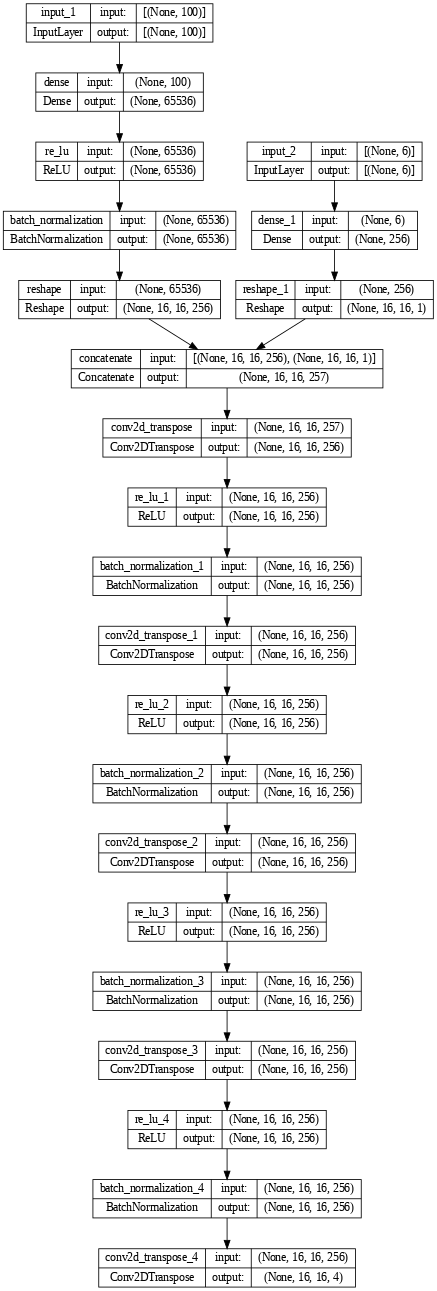

In [ ]:
plot_model(generator, dpi = 60, show_shapes= True)

# Дискриминатор

In [ ]:
def create_discriminator():

  image_input = Input(shape=(img_shape))                                        # Вход для массива (изображения)

  label_input = Input(shape=(6))                                                # Вход для метки класса
  label = Dense(16*16)(label_input)
  label_output = Reshape((16,16,1))(label)

  merge = concatenate([image_input, label_output])                              # Объединение

  x = Conv2D(256, (3,3), strides=(1,1), padding='same')(merge)
  x = LeakyReLU(alpha=0.2)(x)

  x = Flatten()(x)

  x = Dropout(0.4)(x)

  discriminator = Dense(1, activation='sigmoid')  (x)                           # Выход

  discriminator = Model([image_input, label_input], discriminator)

  discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

  discriminator.trainable = False

  return discriminator

In [ ]:
discriminator = create_discriminator()                                          # Создание дискриминатора

## Параметры Дискриминатора

In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 256)                  1792      ['input_4[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 16, 16, 4)]          0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 16, 16, 1)            0         ['dense_2[0][0]']             
                                                                                            

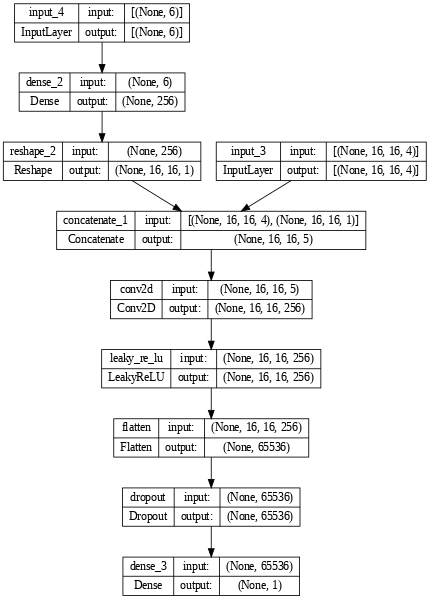

In [ ]:
plot_model(discriminator, dpi = 60, show_shapes=True)

# Вспомогательные фунцкии

In [ ]:
# Функция отрисовки изображений во время обучения

def show_learning_proggress(gen):
  idx=0
  for i in range(6):
    noise = np.random.normal(0, 1, size=(1,random_vec))                         # Вектор(Шум) от [-1, 1]
    sampled_labels = np.arange(0, 6).reshape(-1, 1)                             # Метка класса от 1 до 6
    sampled_labels = utils.to_categorical(sampled_labels, CLASS_COUNT)          # Преобразование в формат OHE
    plt.subplot(1, 6, i+1)
    img = gen.predict([noise, sampled_labels[[i]]], verbose = 0)                # Помещаем в генератор Вектор и Метку класса в формате OHE
    img2 = (img + 1) * 127.5
    plt.imshow(img2[idx, :, :, :].astype('uint8'))
    plt.axis('off')
    plt.title(f'{CLASS_LIST[i]}')
  plt.show()
  plt.close()

In [ ]:
# Функция отрисовки генерируемых изображений после обучения по меткам класса отдельно

def show_generation():
  for j in range(99):
    g = int(input('Введите число: '))
    if g >=0 and g <=5:
      idx=0
      plt.figure(figsize=(3, 3))
      for i in range(1):
        noise = np.random.normal(0, 1, size=(1,random_vec))
        sampled_labels = np.arange(0, 6).reshape(-1, 1)
        sampled_labels = utils.to_categorical(sampled_labels, CLASS_COUNT)
        plt.subplot(1, 1, i+1)
        img = generator.predict([noise, sampled_labels[[g]]], verbose = 0)
        img2 = (img + 1) * 127.5
        plt.imshow(img2[idx, :, :, :].astype('int'))
        plt.axis('off')
      plt.show()
      plt.close()
    else:
      print("Вы ввели неправильное число")

In [ ]:
# Функция сохранения модели

def model_save(i):

  generator.save(f'/content/drive/MyDrive/models/save4/generator_save{i}.h5')
  discriminator.save(f'/content/drive/MyDrive/models/save4/discriminator_save{i}.h5')

In [ ]:
# Функция сохранения весов модели

def model_save_weights(i):

  generator.save_weights(f'/content/drive/MyDrive/models/save4/generator_save_weights{i}.h5')
  discriminator.save_weights(f'/content/drive/MyDrive/models/save4/discriminator_save_weights{i}.h5')

# CGAN Алгоритм

In [ ]:
def CGAN_algoritm (generator, discriminator, epochs=30000, batch_size=batch_size):

  true_labels_img = np.ones((batch_size, 1))
  generated_labels_img = np.zeros((batch_size, 1))

  noise = Input (shape=(random_vec,))
  label = Input(shape=(6))
  img = generator([noise, label])
  checkup = discriminator([img, label])

  CGAN = Model([noise,label],checkup)
  CGAN.compile(loss='binary_crossentropy', optimizer = Adam(0.0002, 0.5))

  view_interval = 100

  d_loss_list = []
  g_loss_list = []
  d_acc_list = []

  for epoch in range(epochs):

    index = np.random.randint(0, x_train.shape[0], batch_size )
    imgs, labels = x_train[index], train_labels[index]

    noise = np.random.normal(0, 1, (batch_size, random_vec))

    gen_imgs = generator.predict([noise, labels], verbose = 0)

    d_loss_real = discriminator.train_on_batch([imgs, labels], true_labels_img)
    d_loss_gen = discriminator.train_on_batch([gen_imgs, labels], generated_labels_img)

    d_loss = 0.5* np.add(d_loss_real,d_loss_gen)

    g_loss = CGAN.train_on_batch([noise, labels],true_labels_img)

    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    d_acc_list.append(100*d_loss[1])

    if ((epoch % view_interval == 0) | (epoch == epochs-1)):

      show_learning_proggress(generator)

      print ('[Epochs: %d] [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))

  fig, axs = plt.subplots(1, 2, figsize=(25, 5))
  axs[0].plot(d_loss_list, label="Ошибка дискриминатора", color='blue')
  axs[0].plot(g_loss_list, label="Ошибка генератора", color='red')
  axs[0].grid()
  axs[0].legend()
  axs[1].plot(d_acc_list, label="Точность распознавания дискриминатора", color='green')
  axs[1].grid()
  axs[1].legend()
  plt.show()
  plt.close()

# Обучение CGAN

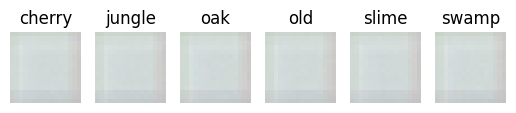

[Epochs: 0] [D loss: 0.742251, acc.: 8.59%] [G loss: 0.611588]


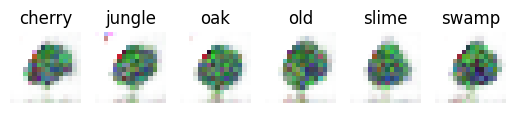

[Epochs: 100] [D loss: 0.673911, acc.: 62.50%] [G loss: 0.952981]


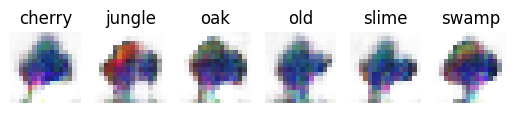

[Epochs: 200] [D loss: 0.589750, acc.: 75.00%] [G loss: 0.927172]


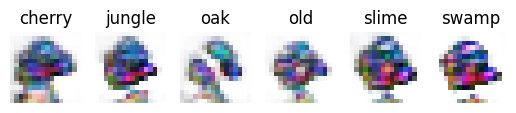

[Epochs: 300] [D loss: 0.621119, acc.: 70.70%] [G loss: 0.853859]


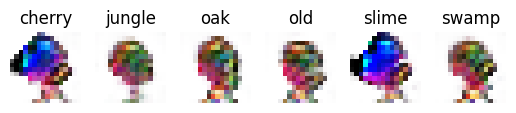

[Epochs: 400] [D loss: 0.513390, acc.: 95.31%] [G loss: 1.128783]


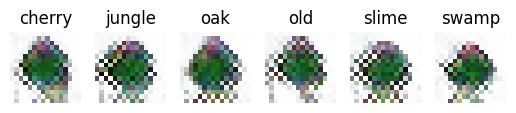

[Epochs: 500] [D loss: 0.497719, acc.: 89.06%] [G loss: 1.240002]


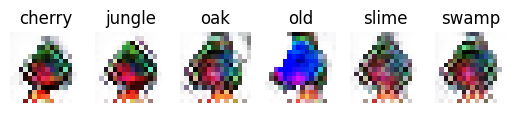

[Epochs: 600] [D loss: 0.503835, acc.: 92.97%] [G loss: 0.997756]


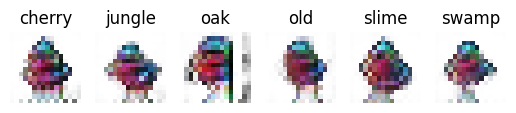

[Epochs: 700] [D loss: 0.577761, acc.: 83.98%] [G loss: 1.028886]


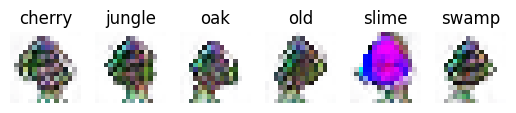

[Epochs: 800] [D loss: 0.497176, acc.: 91.80%] [G loss: 1.157619]


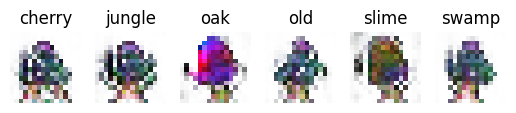

[Epochs: 900] [D loss: 0.486279, acc.: 94.92%] [G loss: 1.075244]


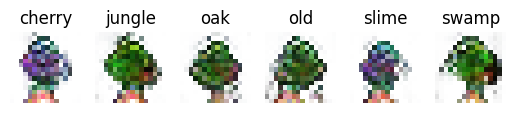

[Epochs: 1000] [D loss: 0.535055, acc.: 87.11%] [G loss: 1.162114]


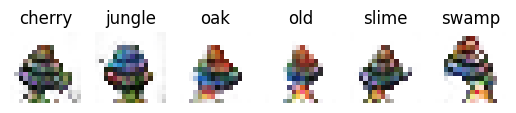

[Epochs: 1100] [D loss: 0.526096, acc.: 85.16%] [G loss: 1.291646]


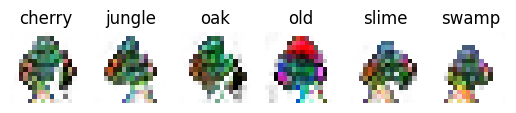

[Epochs: 1200] [D loss: 0.512764, acc.: 85.16%] [G loss: 1.247930]


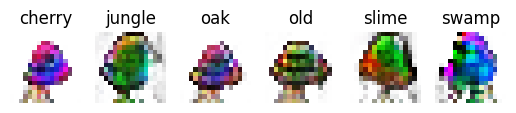

[Epochs: 1300] [D loss: 0.464315, acc.: 89.06%] [G loss: 1.285201]


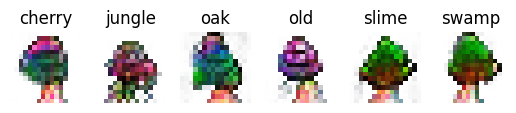

[Epochs: 1400] [D loss: 0.573474, acc.: 77.34%] [G loss: 1.138242]


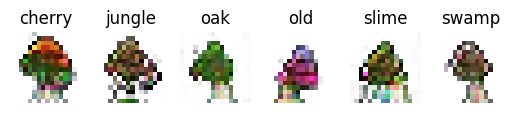

[Epochs: 1500] [D loss: 0.603386, acc.: 76.17%] [G loss: 1.153713]


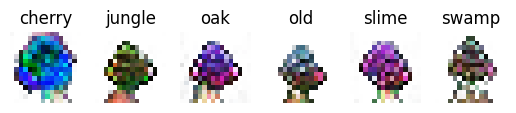

[Epochs: 1600] [D loss: 0.551732, acc.: 86.33%] [G loss: 1.176183]


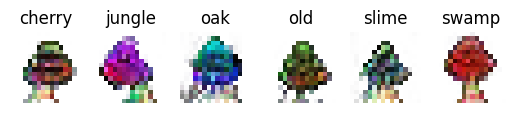

[Epochs: 1700] [D loss: 0.536409, acc.: 86.72%] [G loss: 1.349860]


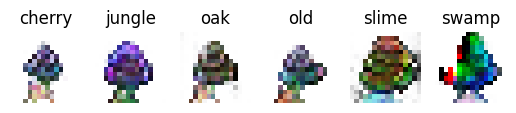

[Epochs: 1800] [D loss: 0.535874, acc.: 86.72%] [G loss: 1.125502]


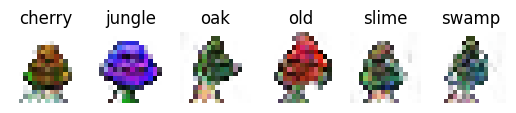

[Epochs: 1900] [D loss: 0.583713, acc.: 75.78%] [G loss: 1.119347]


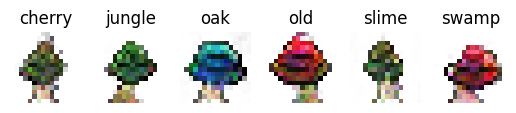

[Epochs: 2000] [D loss: 0.572171, acc.: 76.95%] [G loss: 1.087967]


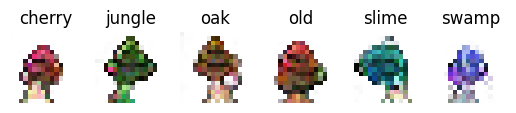

[Epochs: 2100] [D loss: 0.558186, acc.: 77.34%] [G loss: 1.162223]


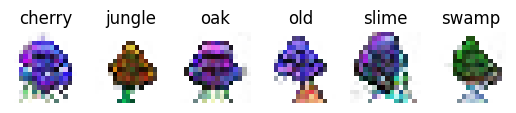

[Epochs: 2200] [D loss: 0.616321, acc.: 71.48%] [G loss: 1.080612]


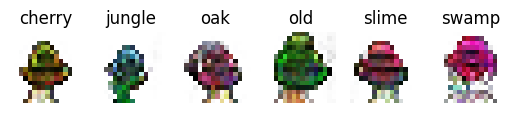

[Epochs: 2300] [D loss: 0.636577, acc.: 67.58%] [G loss: 1.050272]


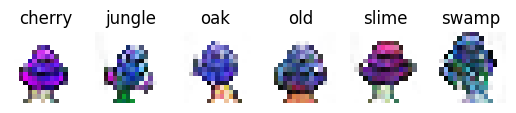

[Epochs: 2400] [D loss: 0.609881, acc.: 74.22%] [G loss: 1.112238]


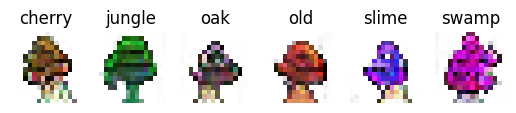

[Epochs: 2500] [D loss: 0.610764, acc.: 71.09%] [G loss: 1.190424]


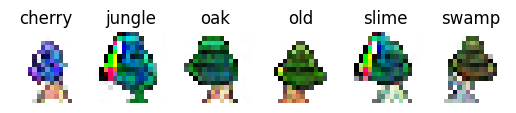

[Epochs: 2600] [D loss: 0.612920, acc.: 72.66%] [G loss: 1.082490]


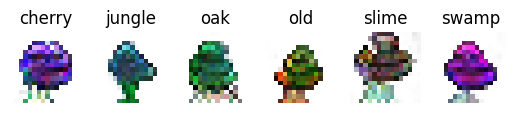

[Epochs: 2700] [D loss: 0.603476, acc.: 69.92%] [G loss: 1.197751]


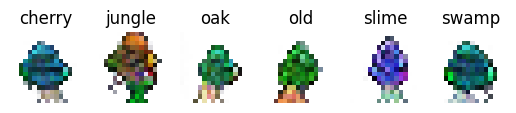

[Epochs: 2800] [D loss: 0.591399, acc.: 71.48%] [G loss: 1.349199]


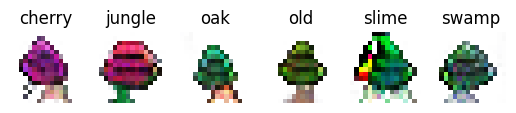

[Epochs: 2900] [D loss: 0.645439, acc.: 63.67%] [G loss: 1.007603]


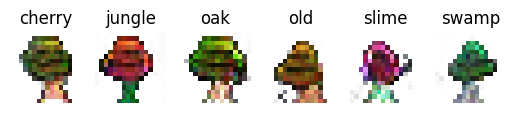

[Epochs: 3000] [D loss: 0.621356, acc.: 66.80%] [G loss: 1.014717]


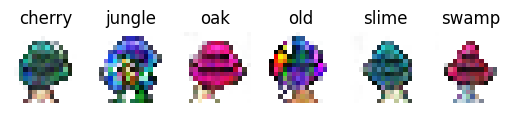

[Epochs: 3100] [D loss: 0.599357, acc.: 73.05%] [G loss: 1.134959]


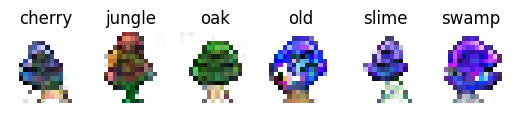

[Epochs: 3200] [D loss: 0.629234, acc.: 69.53%] [G loss: 1.119703]


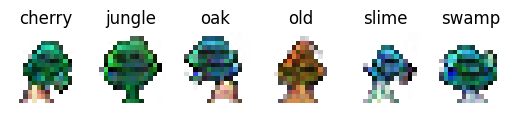

[Epochs: 3300] [D loss: 0.618566, acc.: 70.31%] [G loss: 1.185107]


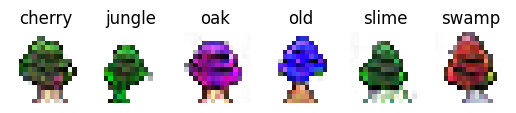

[Epochs: 3400] [D loss: 0.589495, acc.: 73.44%] [G loss: 1.064678]


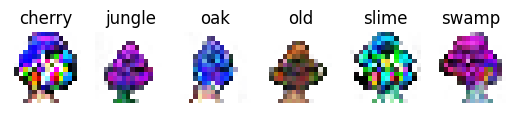

[Epochs: 3500] [D loss: 0.624969, acc.: 68.36%] [G loss: 1.085568]


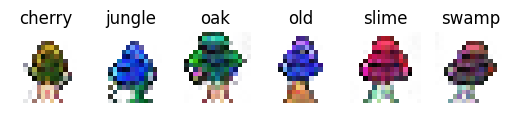

[Epochs: 3600] [D loss: 0.586649, acc.: 74.22%] [G loss: 1.218869]


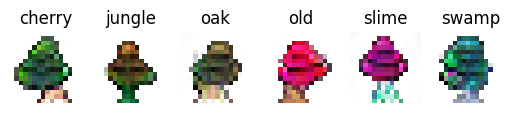

[Epochs: 3700] [D loss: 0.616120, acc.: 69.92%] [G loss: 1.167183]


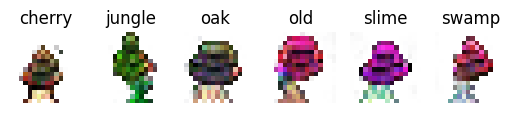

[Epochs: 3800] [D loss: 0.608946, acc.: 71.88%] [G loss: 1.059257]


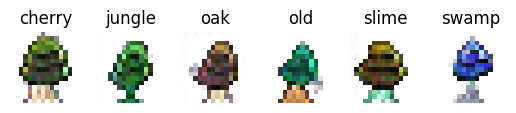

[Epochs: 3900] [D loss: 0.613400, acc.: 71.48%] [G loss: 1.124816]


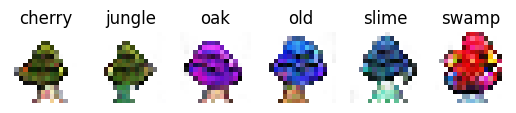

[Epochs: 4000] [D loss: 0.592563, acc.: 73.44%] [G loss: 1.141792]


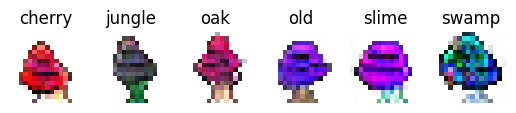

[Epochs: 4100] [D loss: 0.593337, acc.: 69.92%] [G loss: 1.303747]


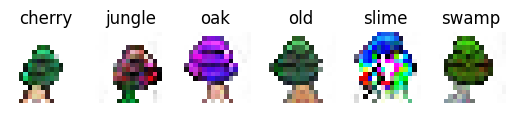

[Epochs: 4200] [D loss: 0.619989, acc.: 69.53%] [G loss: 1.119398]


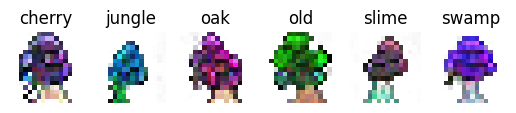

[Epochs: 4300] [D loss: 0.615759, acc.: 68.75%] [G loss: 1.105799]


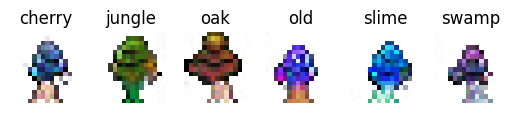

[Epochs: 4400] [D loss: 0.585840, acc.: 75.00%] [G loss: 1.154916]


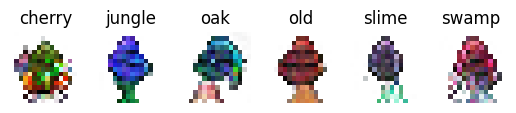

[Epochs: 4500] [D loss: 0.620214, acc.: 67.97%] [G loss: 1.067996]


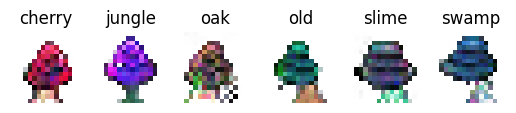

[Epochs: 4600] [D loss: 0.588854, acc.: 73.05%] [G loss: 1.156594]


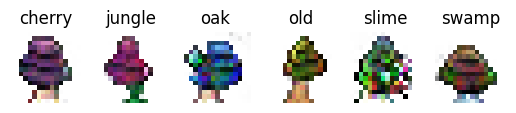

[Epochs: 4700] [D loss: 0.594449, acc.: 71.88%] [G loss: 1.155004]


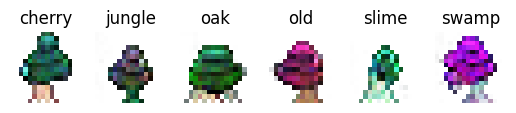

[Epochs: 4800] [D loss: 0.608213, acc.: 68.36%] [G loss: 1.191564]


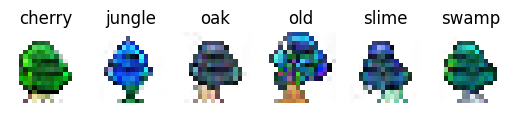

[Epochs: 4900] [D loss: 0.597223, acc.: 70.70%] [G loss: 1.189576]


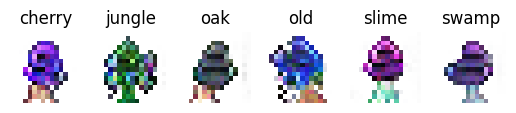

[Epochs: 5000] [D loss: 0.617006, acc.: 67.97%] [G loss: 1.149640]


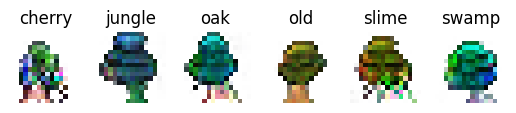

[Epochs: 5100] [D loss: 0.607446, acc.: 69.92%] [G loss: 1.066899]


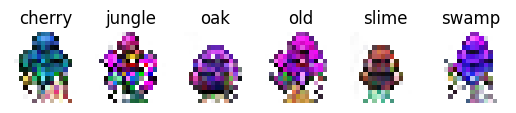

[Epochs: 5200] [D loss: 0.625746, acc.: 61.33%] [G loss: 1.123474]


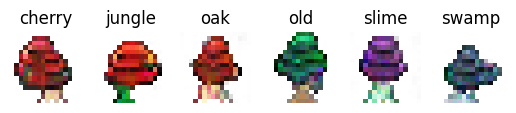

[Epochs: 5300] [D loss: 0.611636, acc.: 66.80%] [G loss: 1.199594]


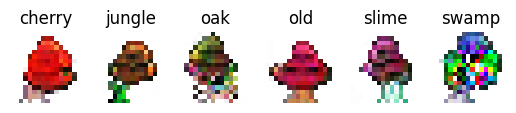

[Epochs: 5400] [D loss: 0.628302, acc.: 65.62%] [G loss: 1.148045]


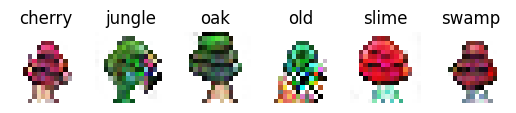

[Epochs: 5500] [D loss: 0.596752, acc.: 72.66%] [G loss: 1.215447]


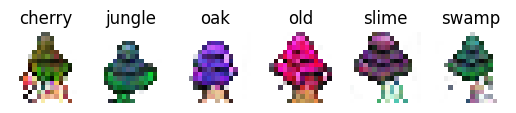

[Epochs: 5600] [D loss: 0.620414, acc.: 66.02%] [G loss: 1.221505]


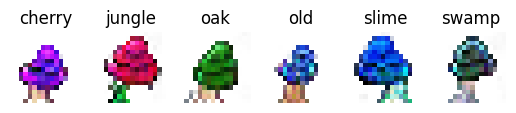

[Epochs: 5700] [D loss: 0.639556, acc.: 63.28%] [G loss: 1.141864]


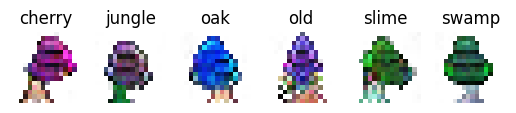

[Epochs: 5800] [D loss: 0.651661, acc.: 61.72%] [G loss: 1.096808]


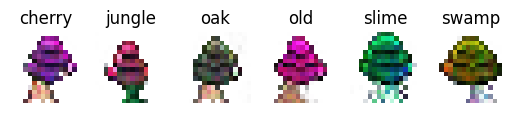

[Epochs: 5900] [D loss: 0.585765, acc.: 73.83%] [G loss: 1.479162]


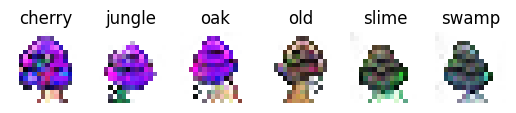

[Epochs: 6000] [D loss: 0.624875, acc.: 63.28%] [G loss: 1.253035]


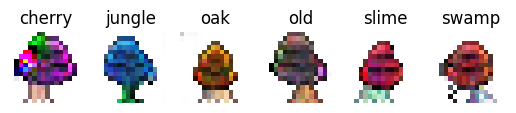

[Epochs: 6100] [D loss: 0.609698, acc.: 66.02%] [G loss: 1.086788]


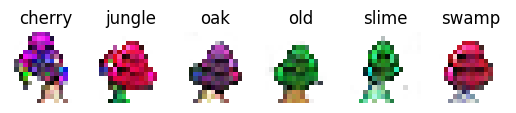

[Epochs: 6200] [D loss: 0.630689, acc.: 63.67%] [G loss: 1.166728]


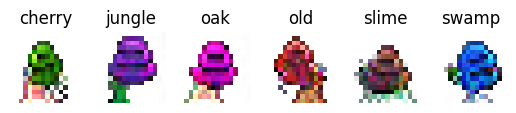

[Epochs: 6300] [D loss: 0.621898, acc.: 63.28%] [G loss: 1.062835]


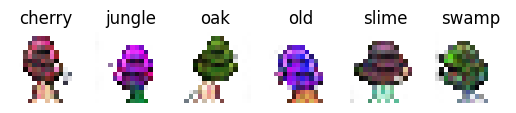

[Epochs: 6400] [D loss: 0.624071, acc.: 66.41%] [G loss: 1.102089]


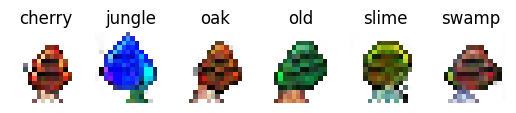

[Epochs: 6500] [D loss: 0.631791, acc.: 62.89%] [G loss: 1.219084]


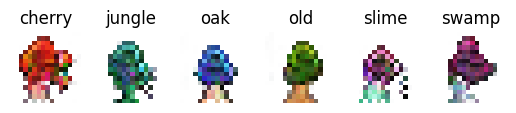

[Epochs: 6600] [D loss: 0.623561, acc.: 63.28%] [G loss: 1.185095]


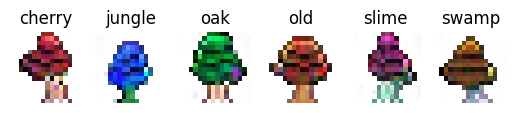

[Epochs: 6700] [D loss: 0.616282, acc.: 68.36%] [G loss: 1.103164]


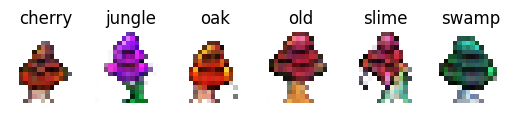

[Epochs: 6800] [D loss: 0.598490, acc.: 65.62%] [G loss: 1.161122]


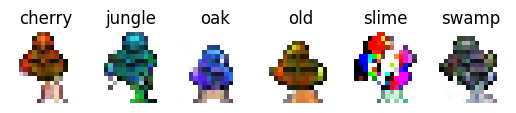

[Epochs: 6900] [D loss: 0.562919, acc.: 75.39%] [G loss: 1.238626]


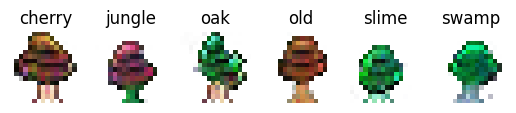

[Epochs: 7000] [D loss: 0.653229, acc.: 64.06%] [G loss: 1.110343]


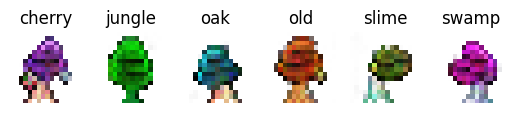

[Epochs: 7100] [D loss: 0.601080, acc.: 68.36%] [G loss: 1.197869]


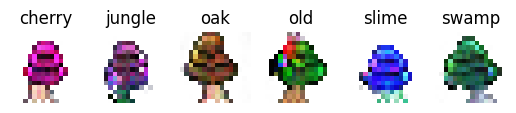

[Epochs: 7200] [D loss: 0.624925, acc.: 67.19%] [G loss: 1.061376]


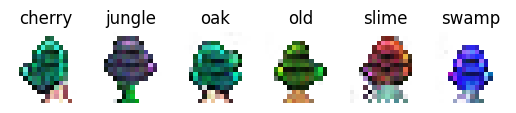

[Epochs: 7300] [D loss: 0.619852, acc.: 66.02%] [G loss: 1.242668]


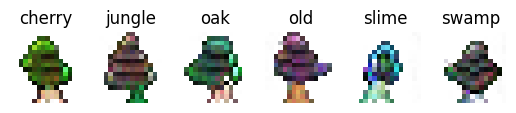

[Epochs: 7400] [D loss: 0.637804, acc.: 60.94%] [G loss: 1.154639]


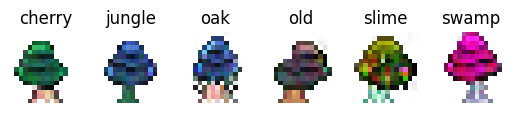

[Epochs: 7500] [D loss: 0.606823, acc.: 66.80%] [G loss: 1.160144]


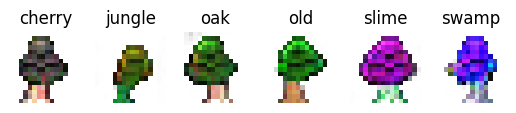

[Epochs: 7600] [D loss: 0.609545, acc.: 68.75%] [G loss: 1.198222]


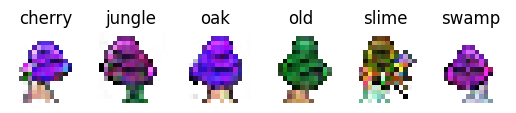

[Epochs: 7700] [D loss: 0.626284, acc.: 64.84%] [G loss: 1.285935]


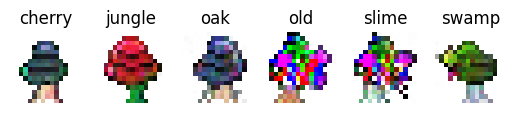

[Epochs: 7800] [D loss: 0.655086, acc.: 61.33%] [G loss: 1.135206]


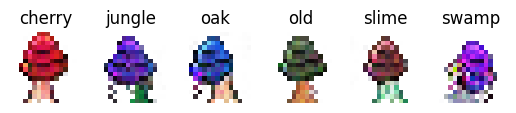

[Epochs: 7900] [D loss: 0.634414, acc.: 64.45%] [G loss: 0.993503]


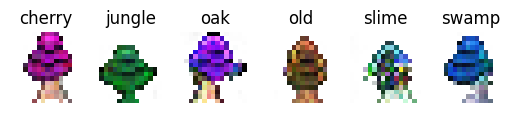

[Epochs: 8000] [D loss: 0.614952, acc.: 68.75%] [G loss: 1.138504]


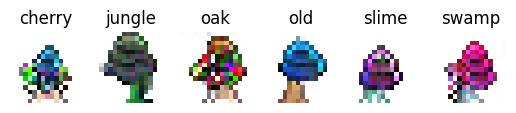

[Epochs: 8100] [D loss: 0.624309, acc.: 67.97%] [G loss: 1.073216]


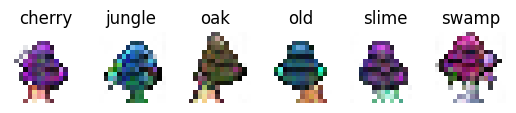

[Epochs: 8200] [D loss: 0.633351, acc.: 60.55%] [G loss: 1.149290]


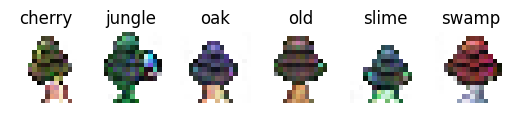

[Epochs: 8300] [D loss: 0.639282, acc.: 61.72%] [G loss: 1.266105]


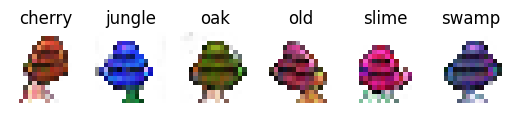

[Epochs: 8400] [D loss: 0.648707, acc.: 61.72%] [G loss: 1.084537]


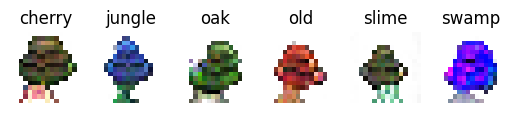

[Epochs: 8500] [D loss: 0.620063, acc.: 67.19%] [G loss: 1.090252]


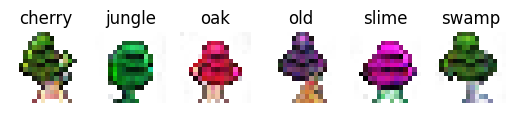

[Epochs: 8600] [D loss: 0.624836, acc.: 65.62%] [G loss: 1.063198]


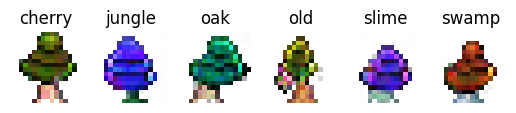

[Epochs: 8700] [D loss: 0.614150, acc.: 67.19%] [G loss: 1.168032]


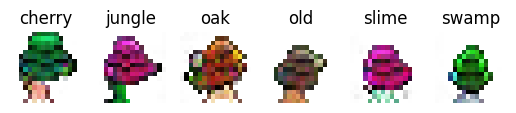

[Epochs: 8800] [D loss: 0.600557, acc.: 69.14%] [G loss: 1.207811]


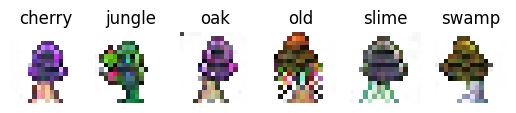

[Epochs: 8900] [D loss: 0.621954, acc.: 65.23%] [G loss: 1.223518]


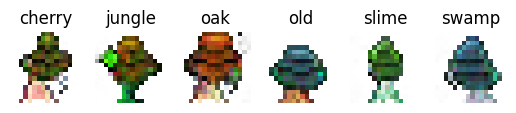

[Epochs: 9000] [D loss: 0.583997, acc.: 73.44%] [G loss: 1.155424]


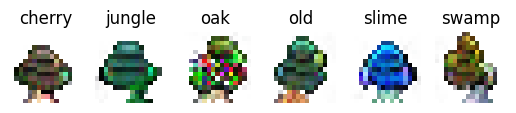

[Epochs: 9100] [D loss: 0.622180, acc.: 65.62%] [G loss: 1.199565]


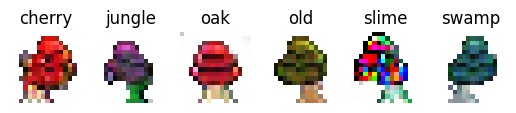

[Epochs: 9200] [D loss: 0.624075, acc.: 66.02%] [G loss: 1.098015]


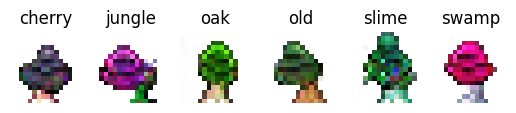

[Epochs: 9300] [D loss: 0.611863, acc.: 66.80%] [G loss: 1.267317]


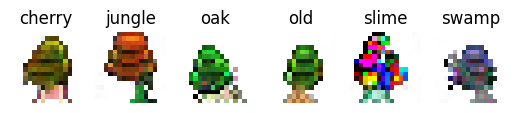

[Epochs: 9400] [D loss: 0.643363, acc.: 62.11%] [G loss: 1.111316]


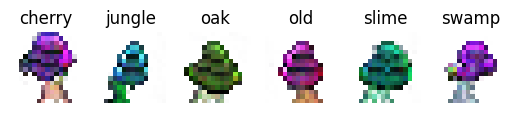

[Epochs: 9500] [D loss: 0.595577, acc.: 67.97%] [G loss: 1.217991]


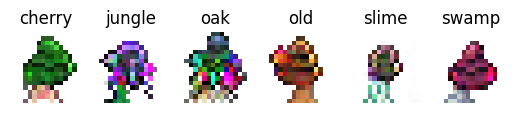

[Epochs: 9600] [D loss: 0.637383, acc.: 66.02%] [G loss: 1.118249]


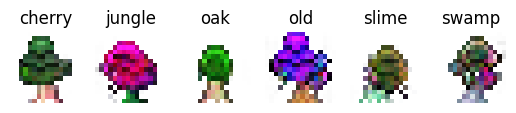

[Epochs: 9700] [D loss: 0.615965, acc.: 67.58%] [G loss: 1.288499]


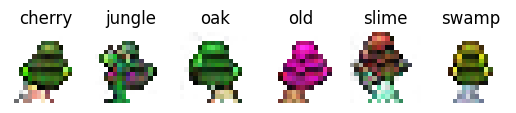

[Epochs: 9800] [D loss: 0.632575, acc.: 63.28%] [G loss: 1.068096]


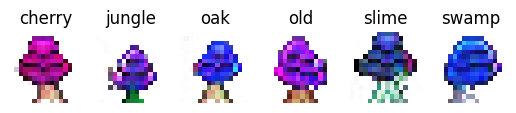

[Epochs: 9900] [D loss: 0.652922, acc.: 60.94%] [G loss: 1.065557]


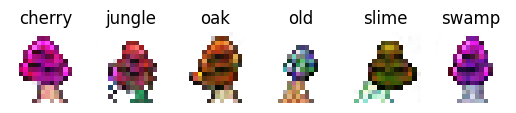

[Epochs: 10000] [D loss: 0.636732, acc.: 64.06%] [G loss: 1.108011]


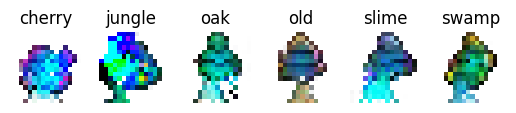

[Epochs: 10100] [D loss: 0.674810, acc.: 58.98%] [G loss: 8.135204]


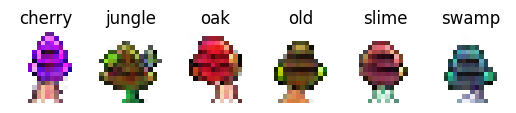

[Epochs: 10200] [D loss: 0.606002, acc.: 67.58%] [G loss: 1.283250]


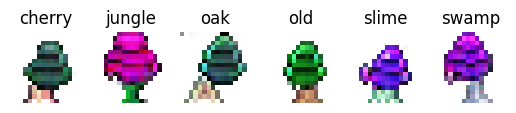

[Epochs: 10300] [D loss: 0.649411, acc.: 59.38%] [G loss: 1.203467]


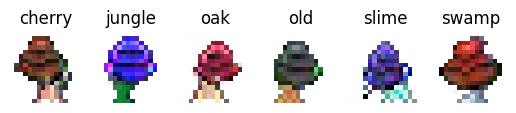

[Epochs: 10400] [D loss: 0.603250, acc.: 69.92%] [G loss: 1.158832]


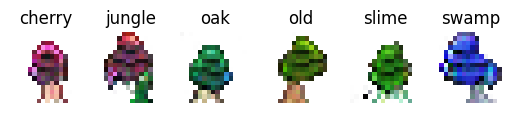

[Epochs: 10500] [D loss: 0.591522, acc.: 71.48%] [G loss: 1.209499]


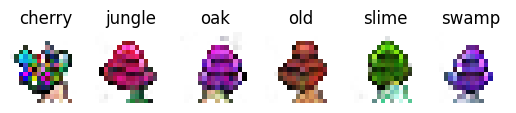

[Epochs: 10600] [D loss: 0.610574, acc.: 65.62%] [G loss: 1.178812]


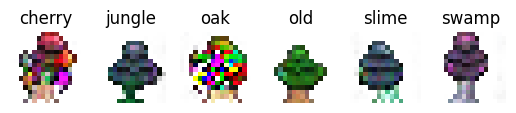

[Epochs: 10700] [D loss: 0.595653, acc.: 69.92%] [G loss: 1.160352]


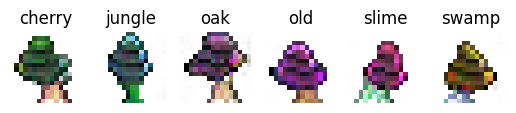

[Epochs: 10800] [D loss: 0.612498, acc.: 64.45%] [G loss: 1.090303]


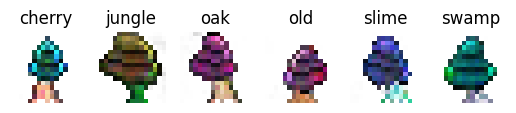

[Epochs: 10900] [D loss: 0.615971, acc.: 64.06%] [G loss: 1.405709]


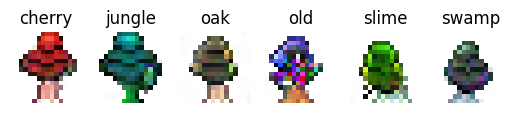

[Epochs: 11000] [D loss: 0.611322, acc.: 64.84%] [G loss: 1.110504]


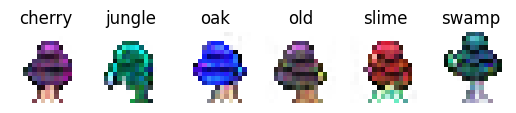

[Epochs: 11100] [D loss: 0.610488, acc.: 67.19%] [G loss: 1.065599]


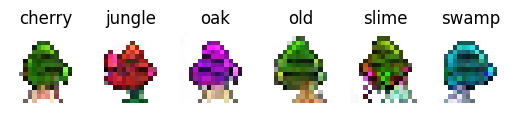

[Epochs: 11200] [D loss: 0.595449, acc.: 67.58%] [G loss: 1.271700]


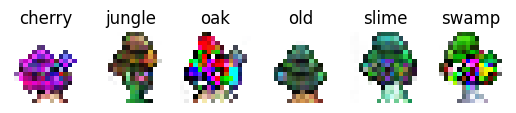

[Epochs: 11300] [D loss: 0.642921, acc.: 61.33%] [G loss: 1.072358]


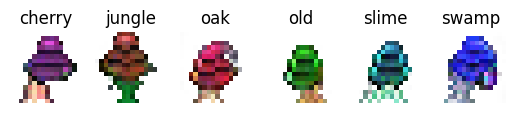

[Epochs: 11400] [D loss: 0.641671, acc.: 61.72%] [G loss: 1.116707]


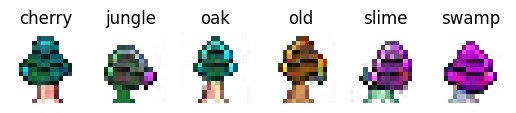

[Epochs: 11500] [D loss: 0.608703, acc.: 69.92%] [G loss: 1.402333]


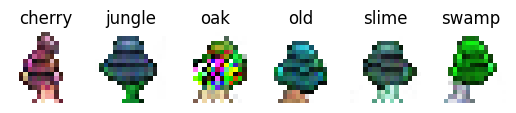

[Epochs: 11600] [D loss: 0.582161, acc.: 69.92%] [G loss: 1.090921]


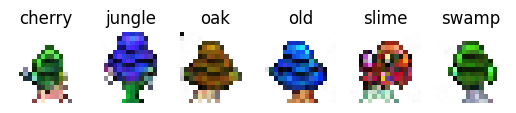

[Epochs: 11700] [D loss: 0.635978, acc.: 62.11%] [G loss: 1.397268]


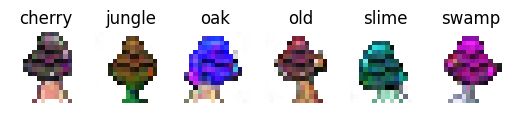

[Epochs: 11800] [D loss: 0.628946, acc.: 67.97%] [G loss: 1.112978]


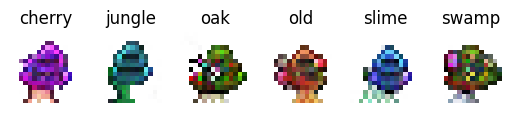

[Epochs: 11900] [D loss: 0.645039, acc.: 60.94%] [G loss: 1.151045]


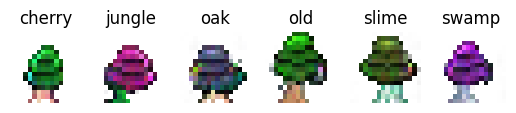

[Epochs: 12000] [D loss: 0.668063, acc.: 60.94%] [G loss: 1.154243]


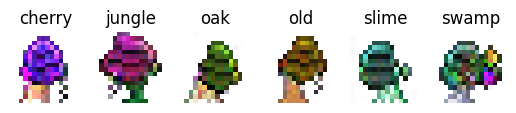

[Epochs: 12100] [D loss: 0.646351, acc.: 64.84%] [G loss: 1.057168]


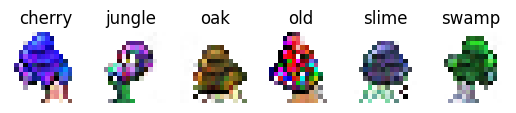

[Epochs: 12200] [D loss: 0.610590, acc.: 67.19%] [G loss: 1.223009]


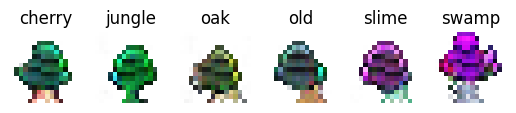

[Epochs: 12300] [D loss: 0.624885, acc.: 64.84%] [G loss: 1.206670]


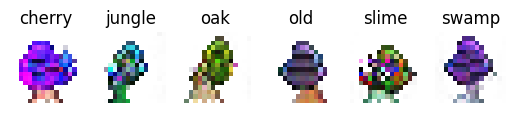

[Epochs: 12400] [D loss: 0.627946, acc.: 60.94%] [G loss: 1.202757]


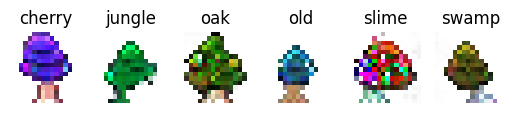

[Epochs: 12500] [D loss: 0.586316, acc.: 70.70%] [G loss: 1.357106]


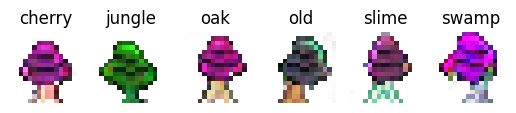

[Epochs: 12600] [D loss: 0.604301, acc.: 63.28%] [G loss: 1.100071]


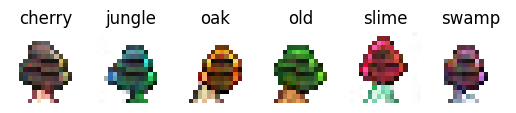

[Epochs: 12700] [D loss: 0.626293, acc.: 63.67%] [G loss: 1.116844]


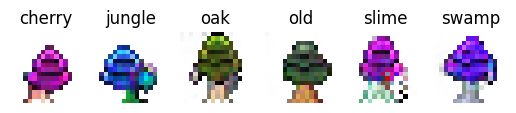

[Epochs: 12800] [D loss: 0.618233, acc.: 62.50%] [G loss: 1.066351]


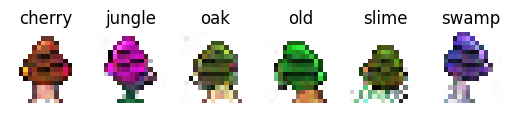

[Epochs: 12900] [D loss: 0.630352, acc.: 64.84%] [G loss: 1.214512]


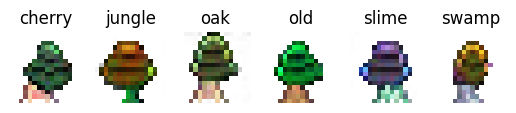

[Epochs: 13000] [D loss: 0.601996, acc.: 66.41%] [G loss: 1.152138]


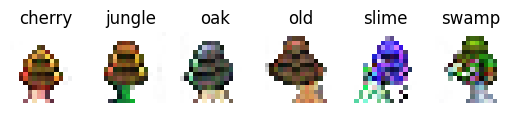

[Epochs: 13100] [D loss: 0.585491, acc.: 70.31%] [G loss: 1.202364]


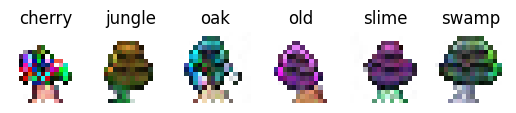

[Epochs: 13200] [D loss: 0.648466, acc.: 62.89%] [G loss: 1.119249]


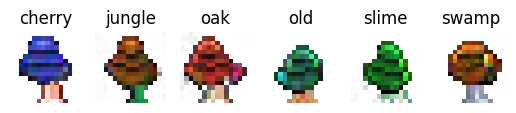

[Epochs: 13300] [D loss: 0.638832, acc.: 63.28%] [G loss: 1.067427]


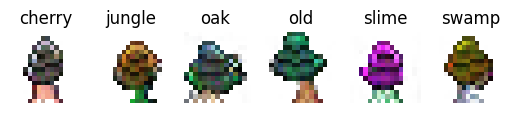

[Epochs: 13400] [D loss: 0.660109, acc.: 59.77%] [G loss: 1.175698]


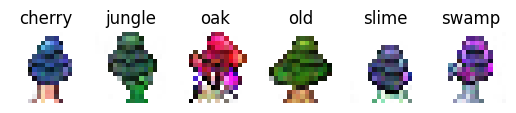

[Epochs: 13500] [D loss: 0.623190, acc.: 64.84%] [G loss: 1.102193]


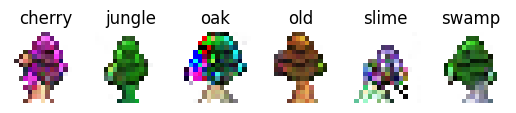

[Epochs: 13600] [D loss: 0.608445, acc.: 66.02%] [G loss: 1.189120]


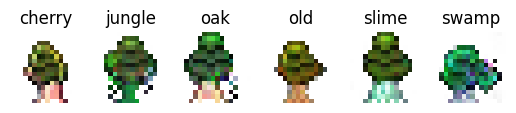

[Epochs: 13700] [D loss: 0.649931, acc.: 62.50%] [G loss: 1.106759]


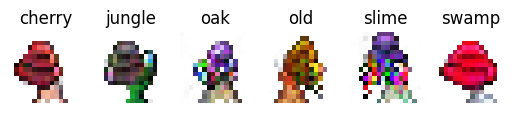

[Epochs: 13800] [D loss: 0.636607, acc.: 63.67%] [G loss: 1.290932]


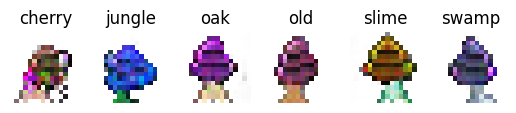

[Epochs: 13900] [D loss: 0.658653, acc.: 60.55%] [G loss: 1.238730]


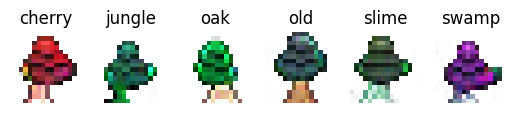

[Epochs: 14000] [D loss: 0.606520, acc.: 70.70%] [G loss: 1.051123]


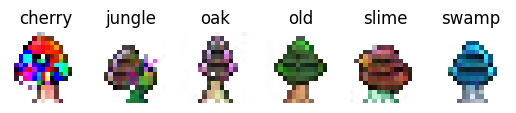

[Epochs: 14100] [D loss: 0.621199, acc.: 65.62%] [G loss: 1.091000]


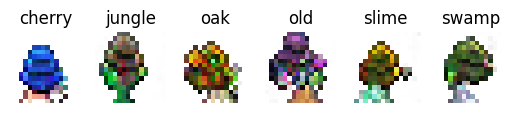

[Epochs: 14200] [D loss: 0.603703, acc.: 66.41%] [G loss: 1.204446]


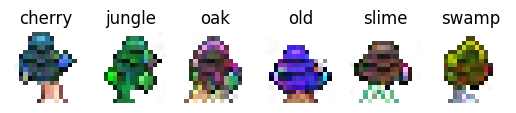

[Epochs: 14300] [D loss: 0.648563, acc.: 60.55%] [G loss: 1.099507]


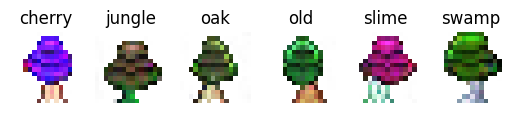

[Epochs: 14400] [D loss: 0.606339, acc.: 67.19%] [G loss: 1.113032]


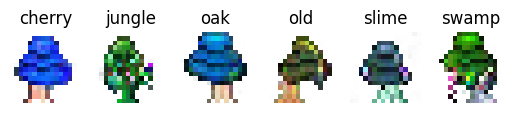

[Epochs: 14500] [D loss: 0.647684, acc.: 61.33%] [G loss: 1.149196]


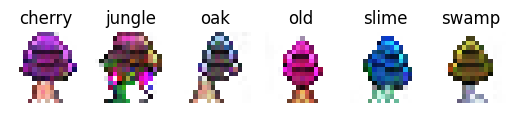

[Epochs: 14600] [D loss: 0.645786, acc.: 61.72%] [G loss: 1.098384]


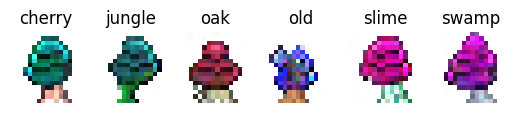

[Epochs: 14700] [D loss: 0.605698, acc.: 67.58%] [G loss: 1.435251]


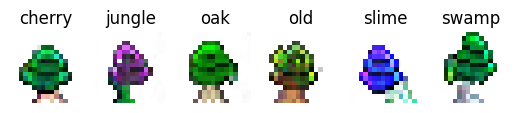

[Epochs: 14800] [D loss: 0.628453, acc.: 64.45%] [G loss: 1.059299]


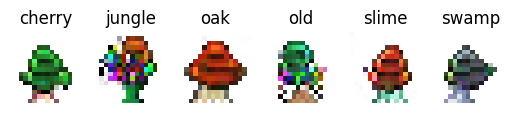

[Epochs: 14900] [D loss: 0.599676, acc.: 66.80%] [G loss: 1.270588]


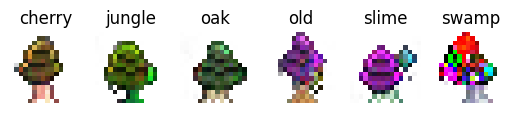

[Epochs: 15000] [D loss: 0.631872, acc.: 59.77%] [G loss: 1.149057]


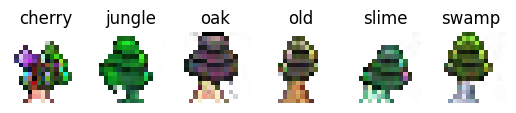

[Epochs: 15100] [D loss: 0.639512, acc.: 62.50%] [G loss: 1.113766]


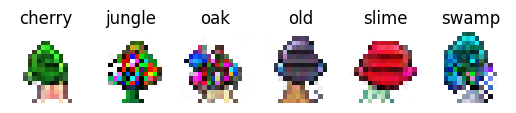

[Epochs: 15200] [D loss: 0.673161, acc.: 60.94%] [G loss: 1.126506]


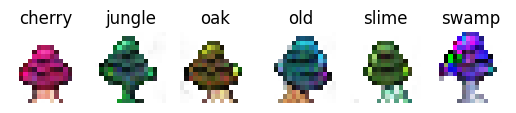

[Epochs: 15300] [D loss: 0.621646, acc.: 64.45%] [G loss: 1.279813]


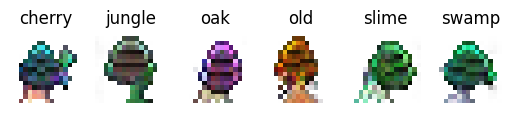

[Epochs: 15400] [D loss: 0.619237, acc.: 66.80%] [G loss: 1.122478]


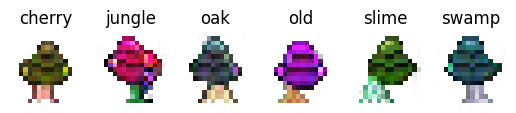

[Epochs: 15500] [D loss: 0.631104, acc.: 60.55%] [G loss: 1.132563]


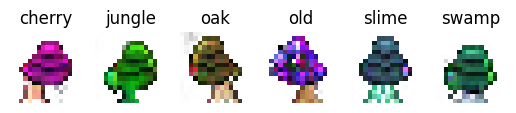

[Epochs: 15600] [D loss: 0.632703, acc.: 61.72%] [G loss: 1.174723]


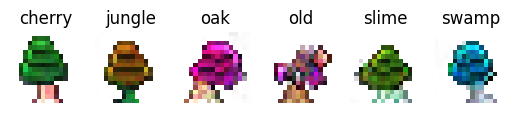

[Epochs: 15700] [D loss: 0.621036, acc.: 64.45%] [G loss: 1.192506]


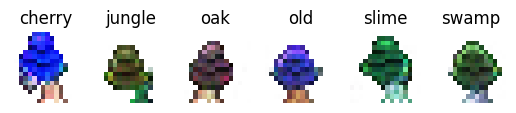

[Epochs: 15800] [D loss: 0.570697, acc.: 71.88%] [G loss: 1.580840]


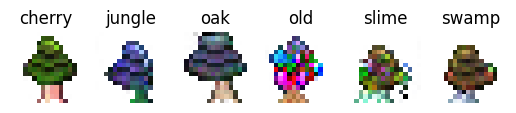

[Epochs: 15900] [D loss: 0.612248, acc.: 65.23%] [G loss: 1.254357]


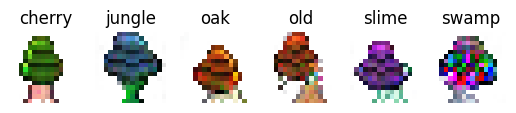

[Epochs: 16000] [D loss: 0.626259, acc.: 62.50%] [G loss: 1.032600]


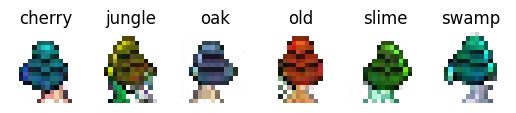

[Epochs: 16100] [D loss: 0.656109, acc.: 58.20%] [G loss: 1.142098]


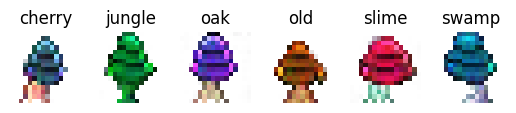

[Epochs: 16200] [D loss: 0.678360, acc.: 56.25%] [G loss: 1.191807]


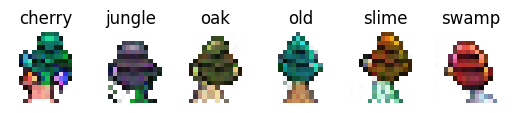

[Epochs: 16300] [D loss: 0.693562, acc.: 60.16%] [G loss: 1.161474]


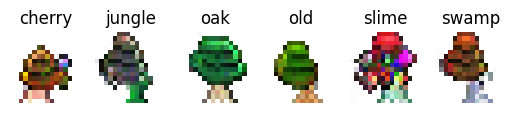

[Epochs: 16400] [D loss: 0.663480, acc.: 57.42%] [G loss: 1.266814]


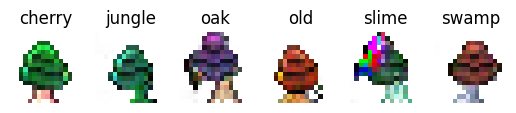

[Epochs: 16500] [D loss: 0.668913, acc.: 57.42%] [G loss: 1.189563]


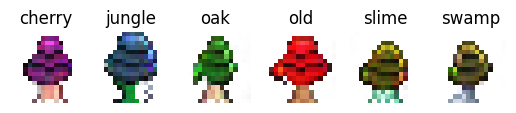

[Epochs: 16600] [D loss: 0.675971, acc.: 59.77%] [G loss: 1.136763]


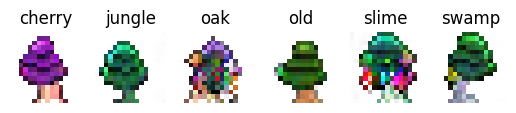

[Epochs: 16700] [D loss: 0.607670, acc.: 66.80%] [G loss: 1.236199]


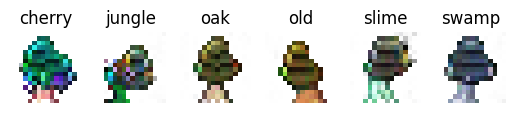

[Epochs: 16800] [D loss: 0.581049, acc.: 68.75%] [G loss: 1.379255]


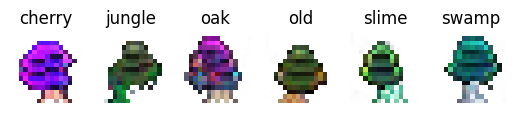

[Epochs: 16900] [D loss: 0.657645, acc.: 63.28%] [G loss: 1.023223]


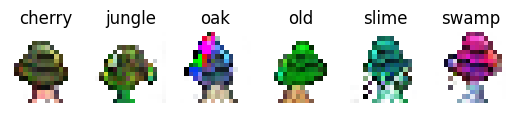

[Epochs: 17000] [D loss: 0.608527, acc.: 68.75%] [G loss: 1.556929]


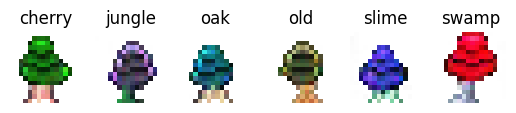

[Epochs: 17100] [D loss: 0.663991, acc.: 59.77%] [G loss: 1.196013]


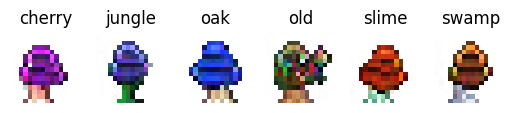

[Epochs: 17200] [D loss: 0.695561, acc.: 56.64%] [G loss: 1.225580]


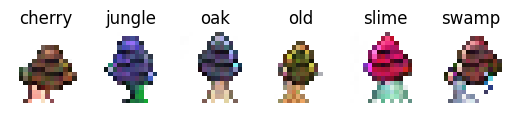

[Epochs: 17300] [D loss: 0.636302, acc.: 60.55%] [G loss: 1.114576]


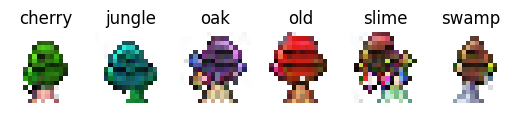

[Epochs: 17400] [D loss: 0.695570, acc.: 52.73%] [G loss: 1.197721]


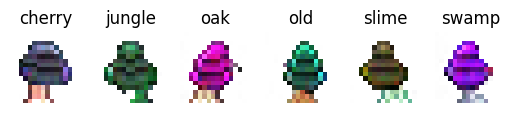

[Epochs: 17500] [D loss: 0.607745, acc.: 65.62%] [G loss: 1.095449]


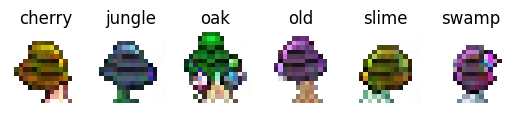

[Epochs: 17600] [D loss: 0.646159, acc.: 61.72%] [G loss: 1.212830]


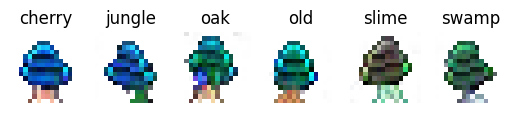

[Epochs: 17700] [D loss: 0.619690, acc.: 65.62%] [G loss: 1.152380]


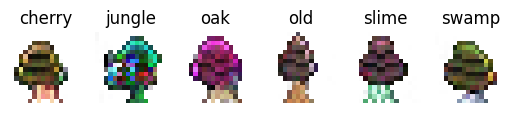

[Epochs: 17800] [D loss: 0.654353, acc.: 62.89%] [G loss: 1.200886]


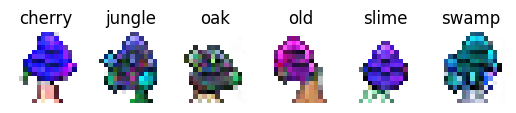

[Epochs: 17900] [D loss: 0.653019, acc.: 60.55%] [G loss: 1.065938]


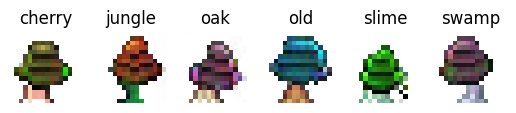

[Epochs: 18000] [D loss: 0.651764, acc.: 62.50%] [G loss: 1.212058]


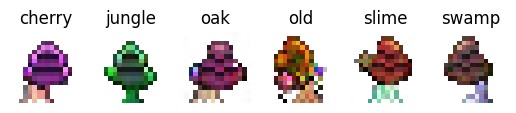

[Epochs: 18100] [D loss: 0.630856, acc.: 65.62%] [G loss: 1.121910]


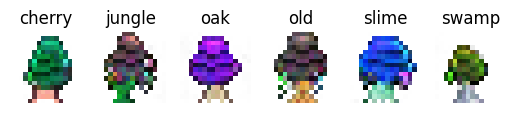

[Epochs: 18200] [D loss: 0.646185, acc.: 62.11%] [G loss: 1.076387]


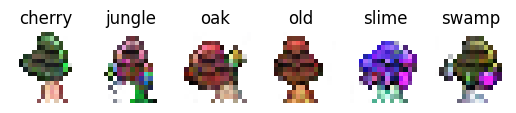

[Epochs: 18300] [D loss: 0.634703, acc.: 60.94%] [G loss: 1.069258]


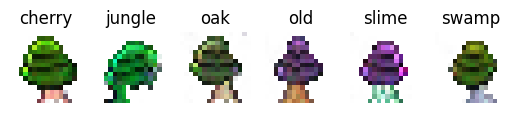

[Epochs: 18400] [D loss: 0.655020, acc.: 60.55%] [G loss: 1.153096]


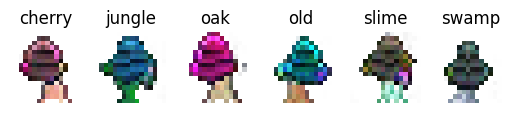

[Epochs: 18500] [D loss: 0.629415, acc.: 66.02%] [G loss: 1.219440]


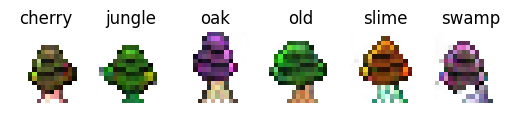

[Epochs: 18600] [D loss: 0.658877, acc.: 60.94%] [G loss: 1.026346]


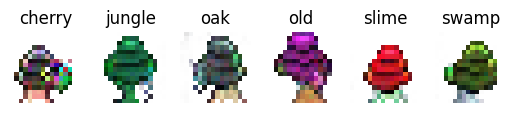

[Epochs: 18700] [D loss: 0.616438, acc.: 64.06%] [G loss: 1.153104]


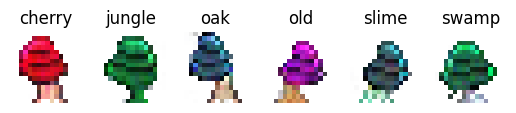

[Epochs: 18800] [D loss: 0.638186, acc.: 61.33%] [G loss: 1.109409]


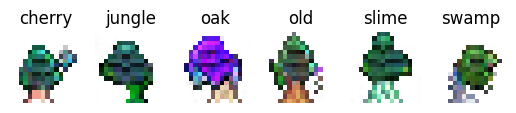

[Epochs: 18900] [D loss: 0.612009, acc.: 64.06%] [G loss: 1.091875]


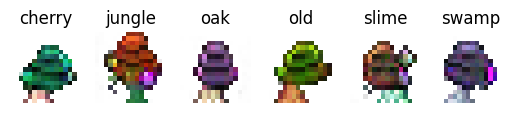

[Epochs: 19000] [D loss: 0.643056, acc.: 59.77%] [G loss: 1.096059]


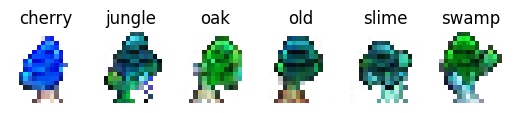

[Epochs: 19100] [D loss: 0.288222, acc.: 95.31%] [G loss: 2.354023]


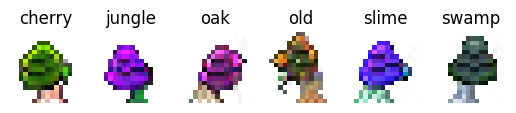

[Epochs: 19200] [D loss: 0.654787, acc.: 62.89%] [G loss: 1.299401]


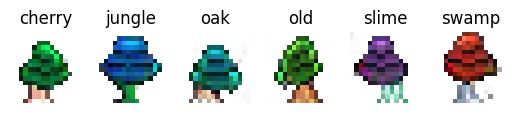

[Epochs: 19300] [D loss: 0.673538, acc.: 59.38%] [G loss: 1.057463]


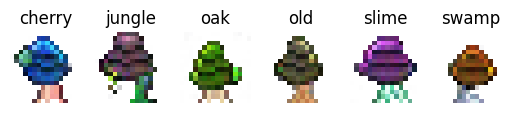

[Epochs: 19400] [D loss: 0.603479, acc.: 68.36%] [G loss: 1.160407]


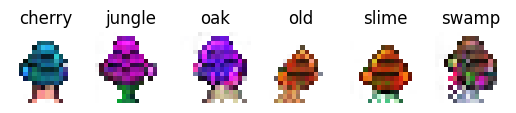

[Epochs: 19500] [D loss: 0.653868, acc.: 58.59%] [G loss: 1.107228]


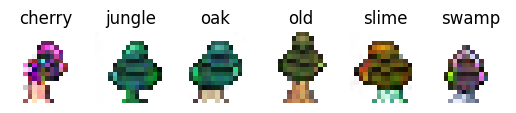

[Epochs: 19600] [D loss: 0.662333, acc.: 58.98%] [G loss: 0.963408]


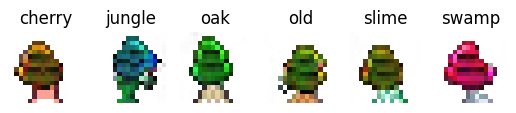

[Epochs: 19700] [D loss: 0.638906, acc.: 64.84%] [G loss: 1.168627]


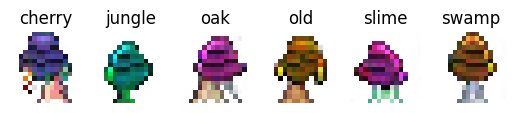

[Epochs: 19800] [D loss: 0.691570, acc.: 55.47%] [G loss: 1.144763]


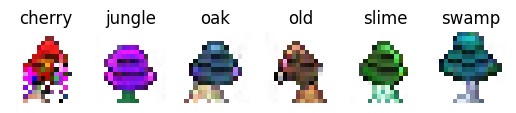

[Epochs: 19900] [D loss: 0.655520, acc.: 60.16%] [G loss: 1.213417]


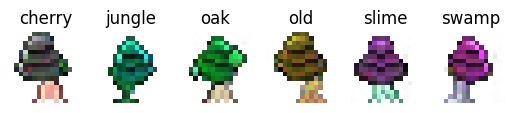

[Epochs: 20000] [D loss: 0.626066, acc.: 64.45%] [G loss: 1.293732]


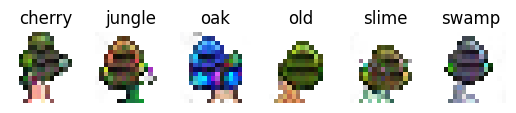

[Epochs: 20100] [D loss: 0.650008, acc.: 58.98%] [G loss: 1.212557]


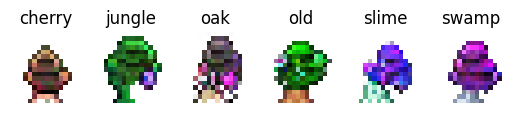

[Epochs: 20200] [D loss: 0.684181, acc.: 55.86%] [G loss: 1.137054]


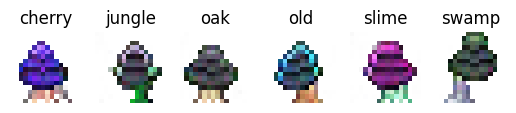

[Epochs: 20300] [D loss: 0.623858, acc.: 64.45%] [G loss: 1.124224]


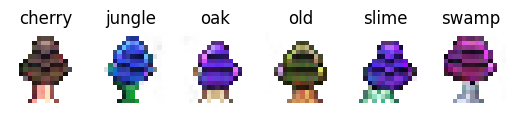

[Epochs: 20400] [D loss: 0.674811, acc.: 59.38%] [G loss: 1.179662]


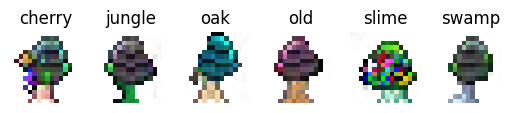

[Epochs: 20500] [D loss: 0.678101, acc.: 58.98%] [G loss: 1.172171]


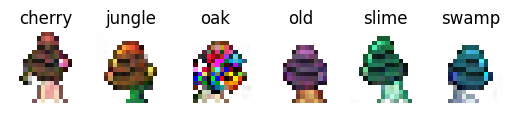

[Epochs: 20600] [D loss: 0.650214, acc.: 60.55%] [G loss: 1.117618]


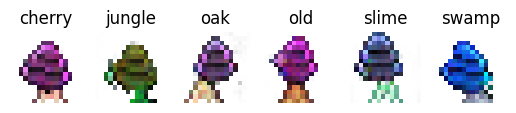

[Epochs: 20700] [D loss: 0.661210, acc.: 63.28%] [G loss: 1.363114]


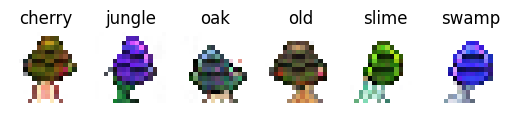

[Epochs: 20800] [D loss: 0.686627, acc.: 57.03%] [G loss: 1.155610]


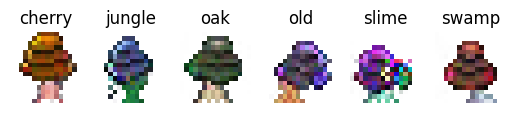

[Epochs: 20900] [D loss: 0.620465, acc.: 64.06%] [G loss: 1.211087]


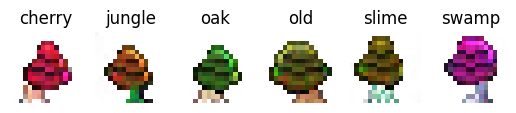

[Epochs: 21000] [D loss: 0.647931, acc.: 60.94%] [G loss: 1.073179]


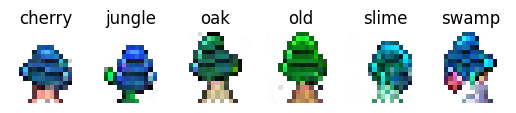

[Epochs: 21100] [D loss: 0.651553, acc.: 60.16%] [G loss: 0.992630]


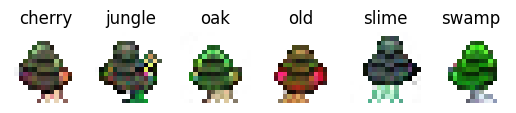

[Epochs: 21200] [D loss: 0.648395, acc.: 61.33%] [G loss: 1.059404]


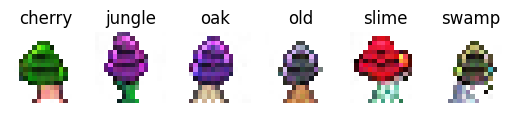

[Epochs: 21300] [D loss: 0.637315, acc.: 62.89%] [G loss: 1.127404]


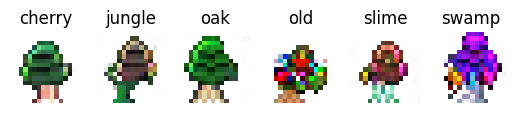

[Epochs: 21400] [D loss: 0.654899, acc.: 58.59%] [G loss: 1.042059]


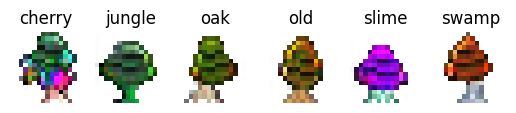

[Epochs: 21500] [D loss: 0.662371, acc.: 59.38%] [G loss: 1.061644]


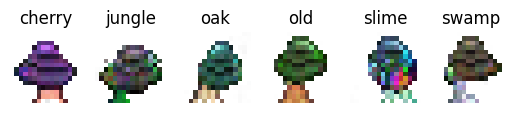

[Epochs: 21600] [D loss: 0.634870, acc.: 62.89%] [G loss: 1.125571]


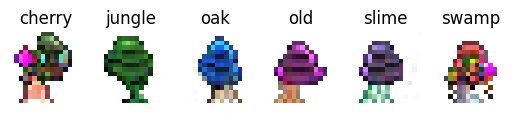

[Epochs: 21700] [D loss: 0.634885, acc.: 64.84%] [G loss: 1.126932]


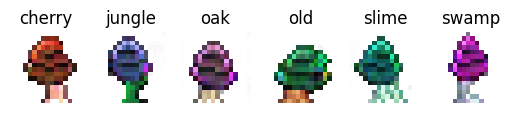

[Epochs: 21800] [D loss: 0.643588, acc.: 59.77%] [G loss: 1.154444]


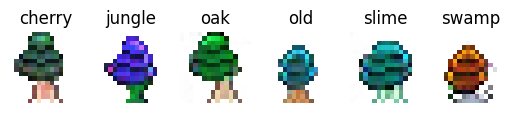

[Epochs: 21900] [D loss: 0.654609, acc.: 59.77%] [G loss: 1.066885]


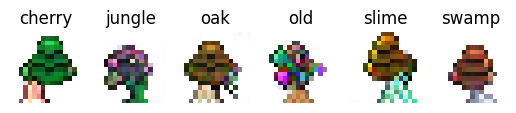

[Epochs: 22000] [D loss: 0.652272, acc.: 61.33%] [G loss: 1.139917]


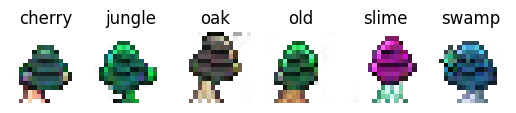

[Epochs: 22100] [D loss: 0.647243, acc.: 63.28%] [G loss: 1.349409]


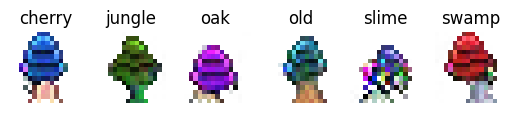

[Epochs: 22200] [D loss: 0.675714, acc.: 57.42%] [G loss: 1.052019]


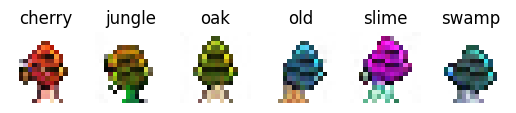

[Epochs: 22300] [D loss: 0.661106, acc.: 60.94%] [G loss: 1.076935]


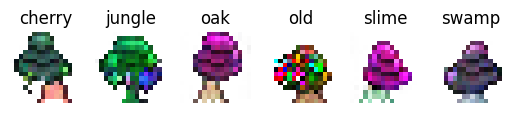

[Epochs: 22400] [D loss: 0.670885, acc.: 60.94%] [G loss: 1.045749]


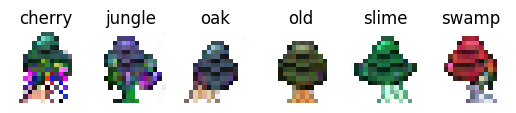

[Epochs: 22500] [D loss: 0.653099, acc.: 62.50%] [G loss: 1.100382]


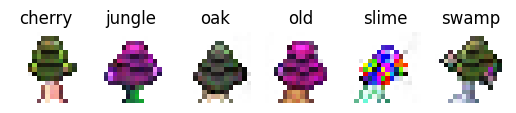

[Epochs: 22600] [D loss: 0.638205, acc.: 64.45%] [G loss: 1.165352]


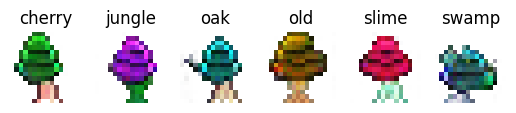

[Epochs: 22700] [D loss: 0.624058, acc.: 66.80%] [G loss: 1.088061]


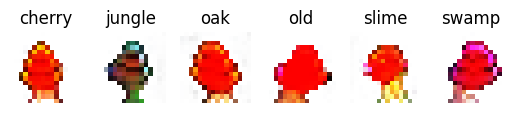

[Epochs: 22800] [D loss: 0.196032, acc.: 97.66%] [G loss: 3.874665]


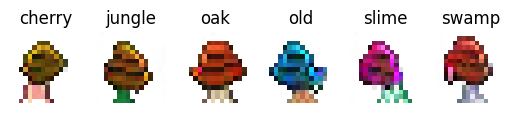

[Epochs: 22900] [D loss: 0.668434, acc.: 58.59%] [G loss: 1.031340]


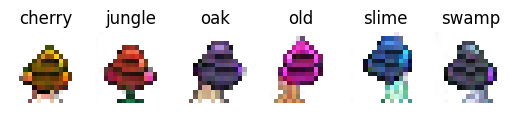

[Epochs: 23000] [D loss: 0.654347, acc.: 61.72%] [G loss: 1.122000]


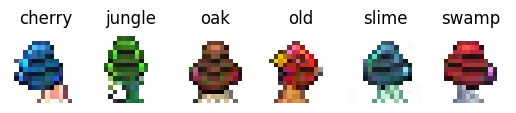

[Epochs: 23100] [D loss: 0.644656, acc.: 60.16%] [G loss: 1.034707]


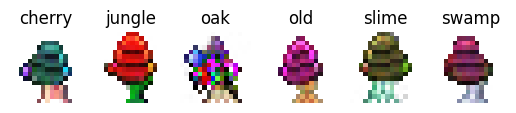

[Epochs: 23200] [D loss: 0.641301, acc.: 67.19%] [G loss: 1.125175]


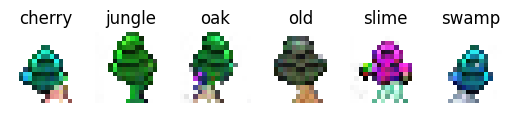

[Epochs: 23300] [D loss: 0.699073, acc.: 52.73%] [G loss: 1.076927]


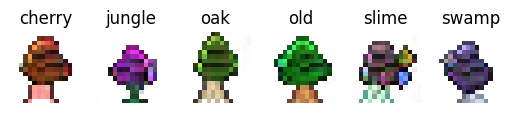

[Epochs: 23400] [D loss: 0.678529, acc.: 57.03%] [G loss: 1.106063]


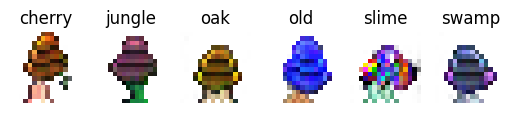

[Epochs: 23500] [D loss: 0.669832, acc.: 57.81%] [G loss: 1.032744]


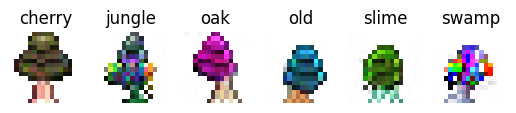

[Epochs: 23600] [D loss: 0.652303, acc.: 63.67%] [G loss: 1.104223]


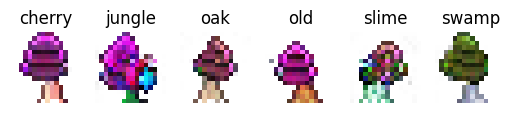

[Epochs: 23700] [D loss: 0.681066, acc.: 57.42%] [G loss: 1.055977]


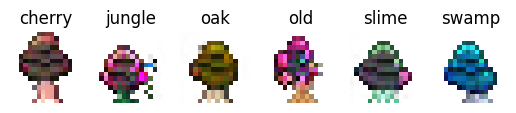

[Epochs: 23800] [D loss: 0.693881, acc.: 58.98%] [G loss: 1.132938]


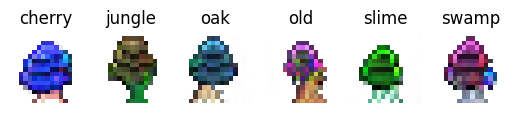

[Epochs: 23900] [D loss: 0.648164, acc.: 64.45%] [G loss: 1.075424]


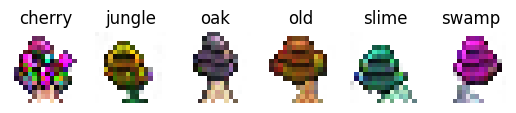

[Epochs: 24000] [D loss: 0.651813, acc.: 60.94%] [G loss: 1.091640]


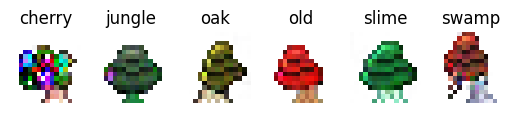

[Epochs: 24100] [D loss: 0.632365, acc.: 67.19%] [G loss: 0.972152]


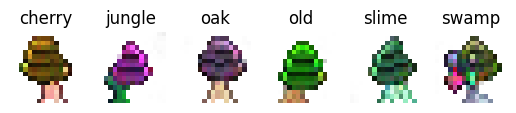

[Epochs: 24200] [D loss: 0.691007, acc.: 58.98%] [G loss: 1.215222]


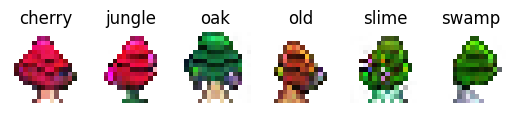

[Epochs: 24300] [D loss: 0.642044, acc.: 59.77%] [G loss: 1.186499]


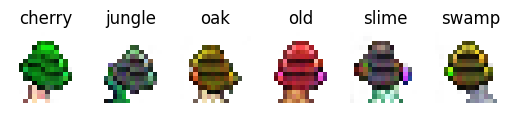

[Epochs: 24400] [D loss: 0.634225, acc.: 65.23%] [G loss: 1.147472]


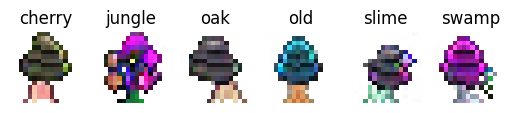

[Epochs: 24500] [D loss: 0.640087, acc.: 63.28%] [G loss: 1.085715]


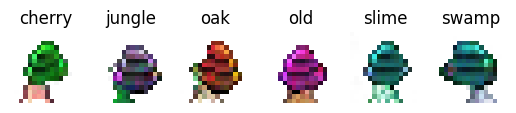

[Epochs: 24600] [D loss: 0.685390, acc.: 58.98%] [G loss: 1.091788]


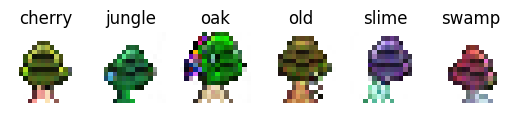

[Epochs: 24700] [D loss: 0.628421, acc.: 64.06%] [G loss: 1.051942]


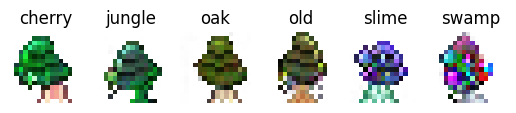

[Epochs: 24800] [D loss: 0.638241, acc.: 59.77%] [G loss: 1.060367]


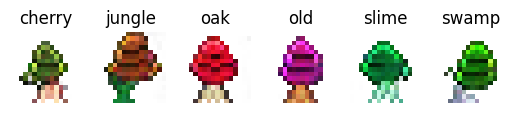

[Epochs: 24900] [D loss: 0.636894, acc.: 60.55%] [G loss: 1.240158]


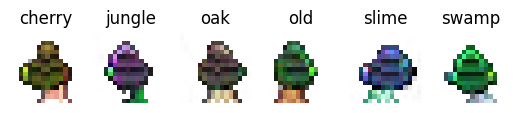

[Epochs: 25000] [D loss: 0.673037, acc.: 56.64%] [G loss: 0.967692]


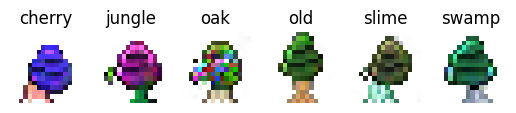

[Epochs: 25100] [D loss: 0.605906, acc.: 66.80%] [G loss: 1.003703]


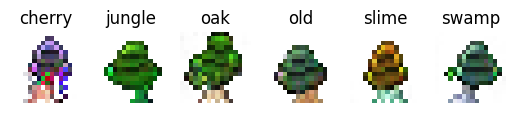

[Epochs: 25200] [D loss: 0.630742, acc.: 62.50%] [G loss: 1.144773]


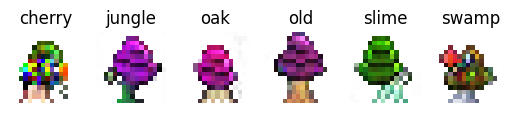

[Epochs: 25300] [D loss: 0.615468, acc.: 64.06%] [G loss: 1.080640]


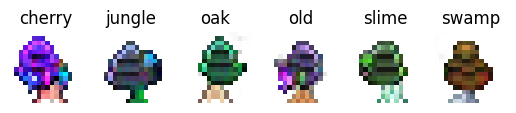

[Epochs: 25400] [D loss: 0.619928, acc.: 64.06%] [G loss: 1.275601]


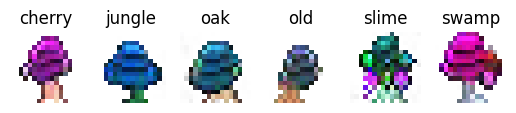

[Epochs: 25500] [D loss: 0.600436, acc.: 66.41%] [G loss: 1.279230]


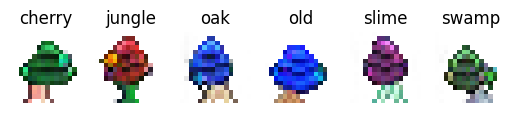

[Epochs: 25600] [D loss: 0.705575, acc.: 58.20%] [G loss: 1.058926]


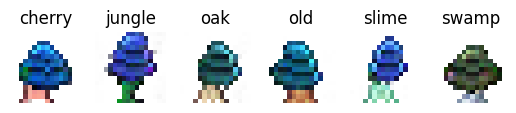

[Epochs: 25700] [D loss: 0.724643, acc.: 53.91%] [G loss: 1.097111]


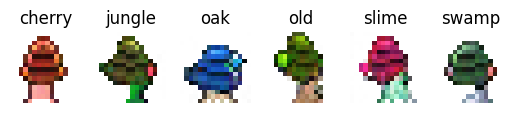

[Epochs: 25800] [D loss: 0.637799, acc.: 61.72%] [G loss: 1.032704]


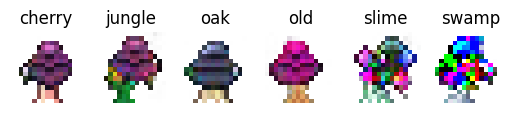

[Epochs: 25900] [D loss: 0.613528, acc.: 64.45%] [G loss: 1.159717]


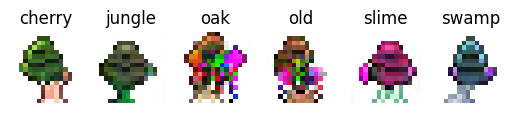

[Epochs: 26000] [D loss: 0.676861, acc.: 59.77%] [G loss: 1.163619]


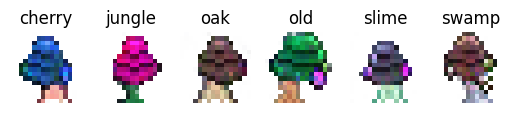

[Epochs: 26100] [D loss: 0.614342, acc.: 67.58%] [G loss: 1.184617]


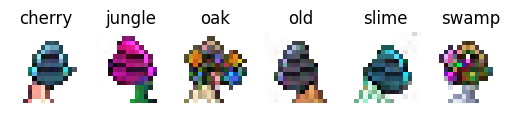

[Epochs: 26200] [D loss: 0.665348, acc.: 62.89%] [G loss: 1.033286]


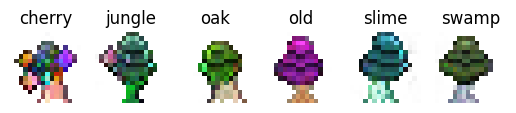

[Epochs: 26300] [D loss: 0.649276, acc.: 60.94%] [G loss: 1.157354]


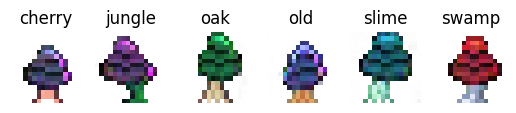

[Epochs: 26400] [D loss: 0.682861, acc.: 56.64%] [G loss: 1.145336]


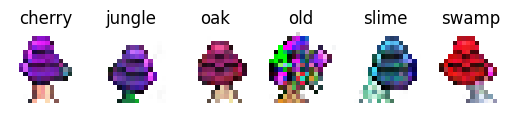

[Epochs: 26500] [D loss: 0.659482, acc.: 61.72%] [G loss: 1.054528]


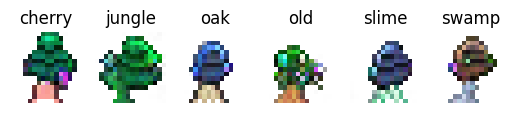

[Epochs: 26600] [D loss: 0.653994, acc.: 61.33%] [G loss: 1.034469]


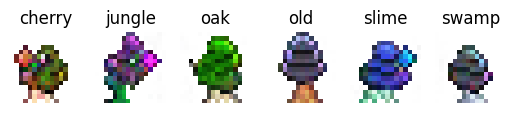

[Epochs: 26700] [D loss: 0.678254, acc.: 58.59%] [G loss: 1.174691]


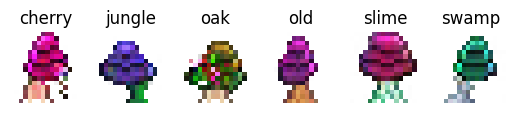

[Epochs: 26800] [D loss: 0.626489, acc.: 63.28%] [G loss: 1.255594]


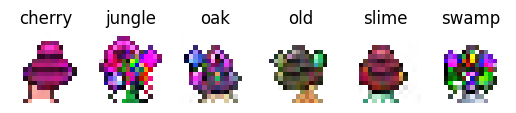

[Epochs: 26900] [D loss: 0.667548, acc.: 59.38%] [G loss: 0.998082]


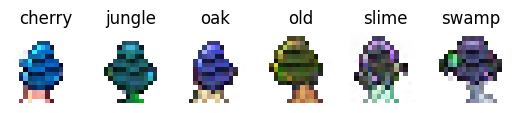

[Epochs: 27000] [D loss: 0.668660, acc.: 57.42%] [G loss: 1.015624]


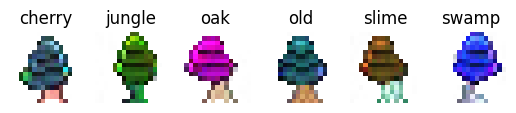

[Epochs: 27100] [D loss: 0.659082, acc.: 61.72%] [G loss: 1.070747]


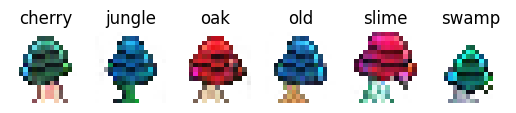

[Epochs: 27200] [D loss: 0.681636, acc.: 58.98%] [G loss: 1.093216]


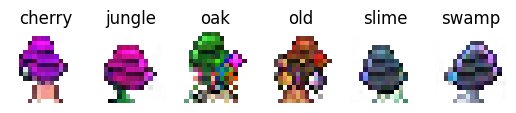

[Epochs: 27300] [D loss: 0.646049, acc.: 62.89%] [G loss: 1.032608]


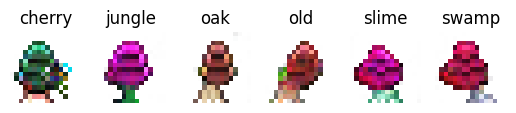

[Epochs: 27400] [D loss: 0.628523, acc.: 64.06%] [G loss: 1.054377]


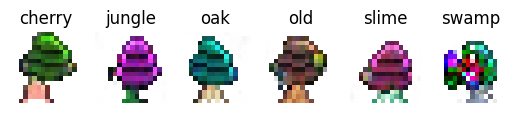

[Epochs: 27500] [D loss: 0.643111, acc.: 64.06%] [G loss: 0.939217]


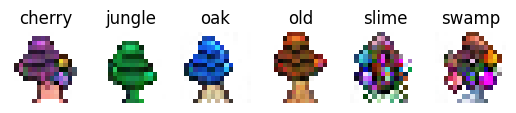

[Epochs: 27600] [D loss: 0.628955, acc.: 62.50%] [G loss: 1.046367]


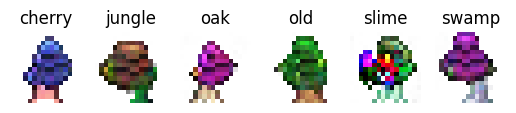

[Epochs: 27700] [D loss: 0.625320, acc.: 64.84%] [G loss: 1.105656]


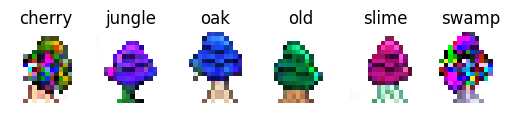

[Epochs: 27800] [D loss: 0.649375, acc.: 62.89%] [G loss: 1.103562]


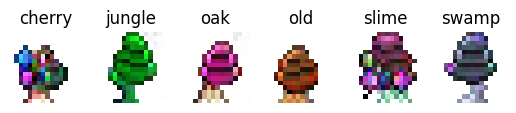

[Epochs: 27900] [D loss: 0.632669, acc.: 61.72%] [G loss: 1.075615]


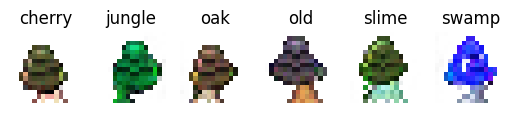

[Epochs: 28000] [D loss: 0.692988, acc.: 56.64%] [G loss: 1.051514]


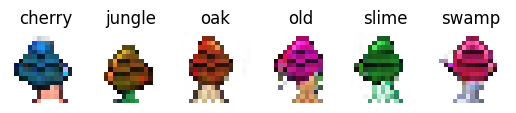

[Epochs: 28100] [D loss: 0.681780, acc.: 61.72%] [G loss: 1.042213]


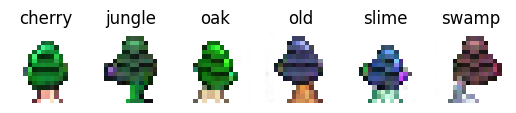

[Epochs: 28200] [D loss: 0.640412, acc.: 61.33%] [G loss: 1.152174]


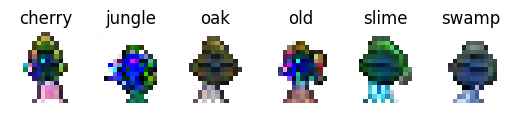

[Epochs: 28300] [D loss: 0.397407, acc.: 77.73%] [G loss: 1.648702]


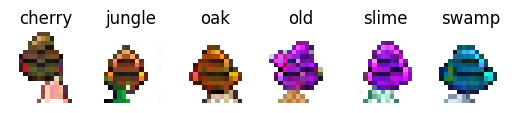

[Epochs: 28400] [D loss: 0.675533, acc.: 60.55%] [G loss: 1.191438]


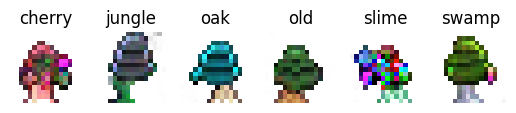

[Epochs: 28500] [D loss: 0.644303, acc.: 62.89%] [G loss: 1.096638]


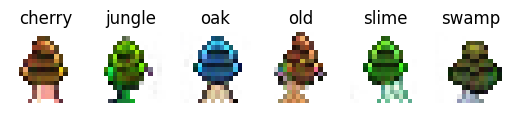

[Epochs: 28600] [D loss: 0.707637, acc.: 52.34%] [G loss: 0.963765]


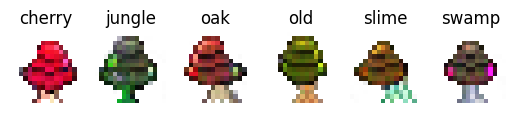

[Epochs: 28700] [D loss: 0.661491, acc.: 61.72%] [G loss: 1.029667]


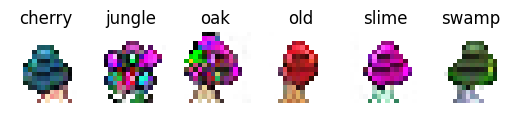

[Epochs: 28800] [D loss: 0.632090, acc.: 63.28%] [G loss: 1.141518]


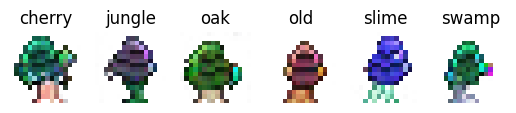

[Epochs: 28900] [D loss: 0.638140, acc.: 64.06%] [G loss: 1.056443]


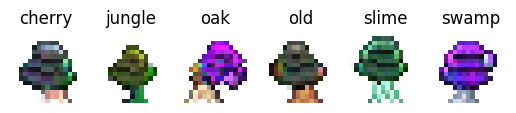

[Epochs: 29000] [D loss: 0.634259, acc.: 62.11%] [G loss: 1.022616]


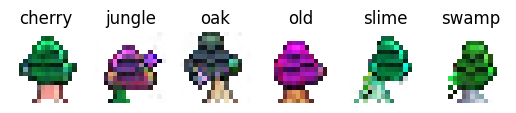

[Epochs: 29100] [D loss: 0.685277, acc.: 62.11%] [G loss: 1.009955]


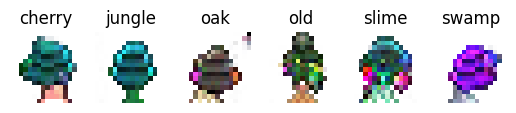

[Epochs: 29200] [D loss: 0.670029, acc.: 57.42%] [G loss: 1.179683]


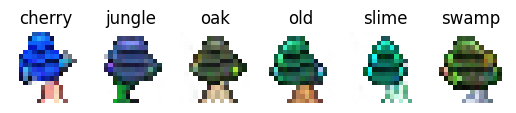

[Epochs: 29300] [D loss: 0.661652, acc.: 64.84%] [G loss: 1.034072]


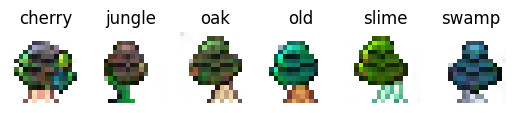

[Epochs: 29400] [D loss: 0.659673, acc.: 60.94%] [G loss: 0.977964]


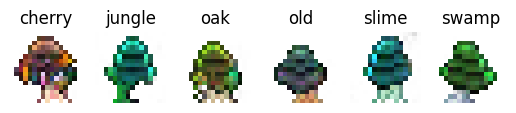

[Epochs: 29500] [D loss: 0.592646, acc.: 67.97%] [G loss: 1.028583]


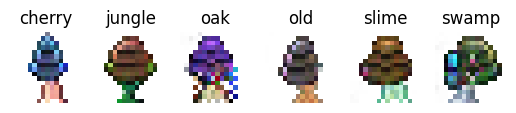

[Epochs: 29600] [D loss: 0.665050, acc.: 60.16%] [G loss: 1.050491]


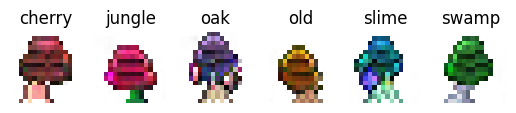

[Epochs: 29700] [D loss: 0.644906, acc.: 60.94%] [G loss: 1.093605]


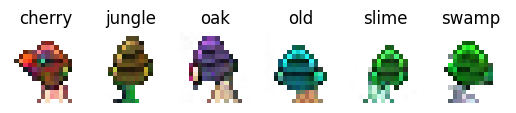

[Epochs: 29800] [D loss: 0.673214, acc.: 58.59%] [G loss: 1.095393]


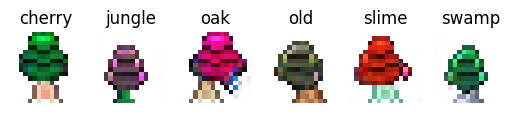

[Epochs: 29900] [D loss: 0.666775, acc.: 57.81%] [G loss: 1.011838]


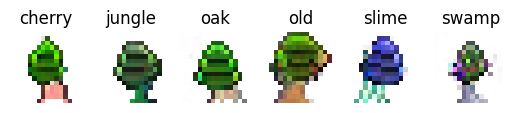

[Epochs: 29999] [D loss: 0.631824, acc.: 64.84%] [G loss: 1.046319]


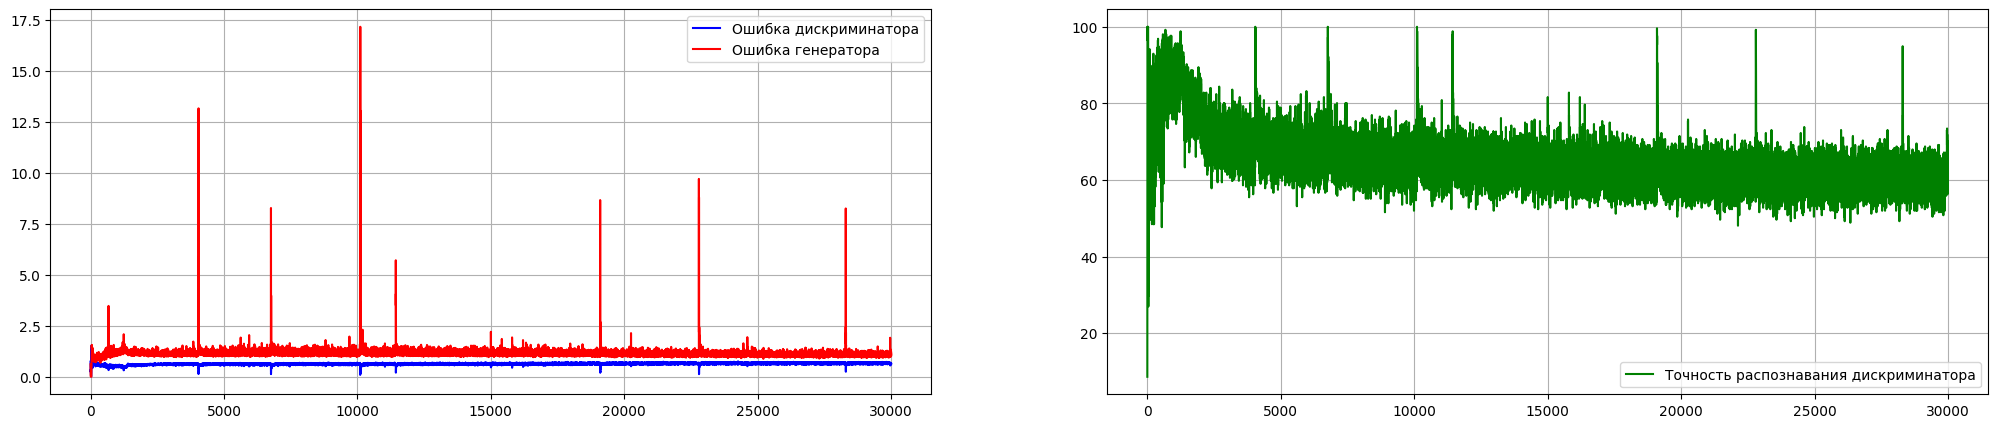

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
CGAN_algoritm(generator, discriminator, 30000)
model_save(0)
model_save_weights(0)

# Демонстрация работы обученного генератора

## Пример генерации метки класса [cherry]

In [ ]:
generator = load_model('/content/drive/MyDrive/Colab Notebooks/stage 5/laptop 1/generator_model_save.h5')

Введите число: 2


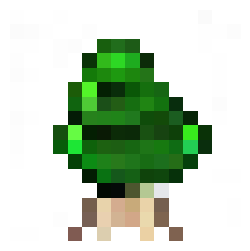

Введите число: 3


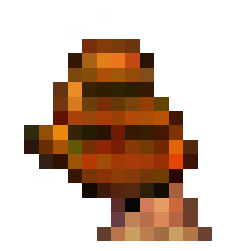

Введите число: 5


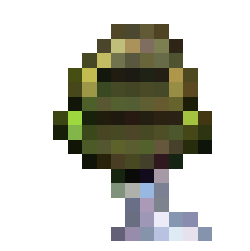

Введите число: 4


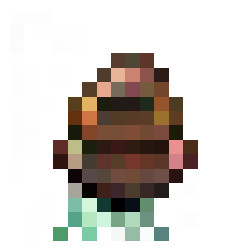

KeyboardInterrupt: ignored

In [ ]:
show_generation()

## Пример генерации метки класса [jungle]

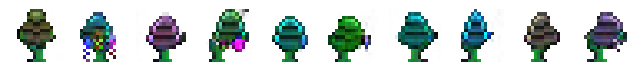

In [ ]:
show_generation(1)

## Пример генерации метки класса [oak]

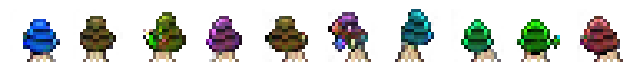

In [ ]:
show_generation(2)

## Пример генерации метки класса [old]

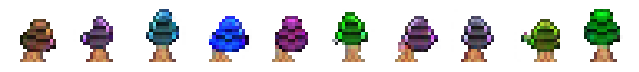

In [ ]:
show_generation(3)

## Пример генерации метки класса [slime]

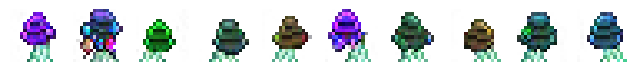

In [ ]:
show_generation(4)

## Пример генерации метки класса [swamp]

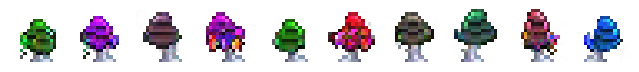

In [ ]:
show_generation(5)

## Общая генерация

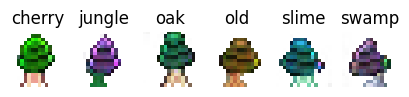

In [ ]:
idx=0

plt.figure(figsize=(5, 5))
for i in range(6):
  noise = np.random.normal(0, 1, size=(1,random_vec)) #Вектор(Шум) от [-1, 1]
  sampled_labels = np.arange(0, 6).reshape(-1, 1) #Лейбл 0,1,2
  sampled_labels = utils.to_categorical(sampled_labels, CLASS_COUNT)
  plt.subplot(1, 6, i+1)
  img = generator.predict([noise, sampled_labels[[i]]], verbose = 0) #Помещаем в генератор
  img2 = (img + 1) * 127.5
  plt.imshow(img2[idx, :, :, :].astype('uint8'))
  plt.axis('off')
  plt.title(f'{CLASS_LIST[i]}')
plt.show()
plt.close()